In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns
sns.set()
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error, r2_score

from scipy import stats
import statsmodels.api as sm

import torch
import torch.nn as nn
import torch.optim as optim

import time
import random

In [2]:
# make the lineplot of timeseries
def time_series_single(name, data, x, y, start, stop, size, color):
    print ('\033[1m'+name+'\033[m')
    print ('Начало периода: '+str(start)+', конец периода: '+str(stop))
    figure(figsize=size)
    sns.lineplot(data[x][data[x]>=start][data[x]<stop], data[y],color=color)
    plt.show()

In [3]:
# create features and targets dataframe
def create_Xy(data_ts, data_ex, exogenous_features,
              col_period,col_target,col_split,col_exgns_featrs, shifts):
    
    # create dataframe and main columns from time=series data
    Xy = pd.DataFrame()
    Xy['Period'] = data_ts[col_period]
    Xy['Split'] = data_ts[col_split]
    Xy['Target'] = data_ts[col_target]

    # create features (targets in past)
    for shift in shifts:
        new_column = Xy['Target'].shift(shift).to_numpy()
        Xy['Target'+'_(t - '+str(shift)+')'] = new_column

    if exogenous_features == True:
        # append features from exogenous data
        Xy[col_exgns_featrs] = data_ex[col_exgns_featrs]

    # drop unnecessary rows
    Xy = Xy[shift:]
    Xy = Xy[(Xy['Split']=='Train') | (Xy['Split']=='Test') | (Xy['Split']=='Forecast')]

    return Xy

In [4]:
def split_Xy(data, features):
    # create train samples
    X_train = pd.DataFrame()
    X_train[features] = Xy[features][Xy['Split']=='Train']
    y_train = pd.DataFrame()
    y_train['Target'] = Xy['Target'][Xy['Split']=='Train']

    # create test samples
    X_test = pd.DataFrame()
    X_test[features] = Xy[features][Xy['Split']=='Test']
    y_test = pd.DataFrame()
    y_test['Target'] = Xy['Target'][Xy['Split']=='Test']

    # create forecast samples
    X_forecast = pd.DataFrame()
    X_forecast[features] = Xy[features][Xy['Split']=='Forecast']
    
    return X_train, y_train, X_test, y_test, X_forecast

In [5]:
# build the forecast
def make_forecast_NN(length_frcst, exogenous_features, col_exgns_featrs, data, model):
    forecasts = []
    input_features = data[0:1].to_numpy()
    
    if exogenous_features == False:
        num_cols = data.shape[1]
        
        
        counter = 1
        for i in range(length_frcst):
            forecast = model(torch.tensor(input_features, dtype=torch.float)).cpu().detach().numpy()
            forecasts.append(forecast)
            counter +=1
            add_to_input = data[i+1:i+2].to_numpy()
            add_to_input = add_to_input[~np.isnan(add_to_input)].reshape(1,-1)
            input_features = np.hstack((np.array(forecasts)[::-1][:num_cols].reshape(1,-1), add_to_input))
    
    if exogenous_features == True:
        num_cols = data.shape[1] - len(col_exgns_featrs)
        
        ts_data = pd.DataFrame()
        ts_data[data.columns[:num_cols]] = data[data.columns[:num_cols]]
        
        ex_data = pd.DataFrame()
        ex_data[data.columns[num_cols:]] = data[data.columns[num_cols:]]
        
        counter = 1
        for i in range(length_frcst):
            forecast = model(torch.tensor(input_features, dtype=torch.float)).cpu().detach().numpy()
            forecasts.append(forecast)
            counter +=1
            ts_add_to_input = ts_data[i+1:i+2].to_numpy()
            ts_add_to_input = ts_add_to_input[~np.isnan(ts_add_to_input)].reshape(1,-1)
            input_features = np.hstack((np.array(forecasts)[::-1][:num_cols].reshape(1,-1), ts_add_to_input))
            input_features = np.hstack((input_features, ex_data[i+1:i+2].to_numpy().reshape(1,-1)))
        
        
        
        


    return np.array(forecasts).reshape(-1,1)

In [6]:
# create model quality report
def make_report_NN(name_report,
                true_train, true_test, predict_train, predict_test, forecast, 
                train_period, test_period, forecast_period, 
                model, features, graph_train, graph_test, graph_forecast, graph_coef,
                size_graph_1_1, size_graph_1_2, size_graph_2_1, size_graph_2_2, size_graph_3, size_graph_4):
    print ()
    print ('\033[4m' +'\033[1m' + 'REPORT - %s' %name_report + '\033[m')
    print ()
    print ('\033[1m' + 'Model' + '\033[m', model)
    print ('\033[1m' + 'Features' + '\033[m', features)
    print ()

    if graph_train is True:
#         print ('\033[4m' + 'TRAIN PERIOD: %s - %s' %(train_period[0],train_period[-1]) + '\033[m')
        print ('\033[4m' + '\033[1m' + 'TRAIN PERIOD:' +'\033[m' + '\033[4m', train_period[0],train_period[-1], '\033[m')
        print ()
        size = size_graph_1_1
        figure(figsize=size)
        plt.plot(train_period, true_train, color = 'green', label='True train')
        plt.plot(train_period, predict_train, color = 'red', label='Predict train')
        plt.xlabel("Period")
        plt.ylabel("Value")
        plt.legend()
        plt.show()
        print ('Average value: %u, RMSE: %u, %f%% (RMSE/AVG)' %(
            np.round(np.mean(true_train),2),
            np.round(mean_squared_error(true_train, predict_train)**0.5,2),
            100*np.round(mean_squared_error(true_train, predict_train)**0.5,2) / np.round(np.mean(true_train),2)
        ))
        print ('Coefficient of determination:', np.round(r2_score(true_train, predict_train),4))

        errors = true_train - predict_train
        size = (size_graph_1_2)
        figure(figsize=size)
        plt.plot(train_period, errors, color = 'red', label='Errors (true - predict)')
        plt.xlabel("Period")
        plt.ylabel("Value")
        plt.legend()
        plt.show()

        print ('Остатки модели смещены на ' + str(np.round(errors.to_numpy().mean(),2)))
        print ('Смещение составляет ' + str(np.round(errors.to_numpy().mean()*100/predict_train.mean(),2)) + 
               '%' + ' от среднего значения прогнозируемой величины в', np.round(predict_train.mean(),2))
        print('Критерий Дики-Фуллера: ' + 'p=' +
              str(np.round(sm.tsa.stattools.adfuller(errors.to_numpy())[1],150)))
        print ()

    if graph_test is True:
        print ('\033[4m' + '\033[1m' + 'TEST PERIOD:' +'\033[m' + '\033[4m', test_period[0],test_period[-1], '\033[m')
        print ()
        size = size_graph_2_1
        figure(figsize=size)
        plt.plot(test_period, true_test, color = 'green', label='True test')
        plt.plot(test_period, predict_test, color = 'red', label='Predict test')
        plt.xlabel("Period")
        plt.ylabel("Value")
        plt.legend()
        plt.show()
        print ('Average value: %u, RMSE: %u, %f%% (RMSE/AVG)' %(
            np.round(np.mean(true_test),2),
            np.round(mean_squared_error(true_test, predict_test)**0.5,2),
            100*np.round(mean_squared_error(true_test, predict_test)**0.5,2) / np.round(np.mean(true_test),2)
        ))
        print ('Coefficient of determination:', np.round(r2_score(true_test, predict_test),4))

        errors = true_test - predict_test
        size = size_graph_2_2
        figure(figsize=size)
        plt.plot(test_period, errors, color = 'red', label='Errors (true - predict)')
        plt.xlabel("Period")
        plt.ylabel("Value")
        plt.legend()
        plt.show()

        print ('Остатки модели смещены на ' + str(np.round(errors.to_numpy().mean(),2)))
        print ('Смещение составляет ' + str(np.round(errors.to_numpy().mean()*100/predict_test.mean(),2)) + 
               '%'  + ' от среднего значения прогнозируемой величины в', np.round(predict_test.mean(),2))
        print('Критерий Дики-Фуллера: ' + 'p=' +
              str(np.round(sm.tsa.stattools.adfuller(errors.to_numpy())[1],150)))
        print ()
        
    if graph_forecast is True:
        print ('\033[4m' + '\033[1m' + 'TRAIN + TEST + FORECAST:' +'\033[m' + '\033[4m', test_period[0],forecast_period[-1], '\033[m')
        print ()
        size = size_graph_3
        figure(figsize=size)
        plt.plot(train_period, true_train, color = 'green', label='True train')
        plt.plot(train_period, predict_train, color = 'red', label='Predict train')
        plt.plot(test_period, true_test, color = 'darkgreen', label='True test')
        plt.plot(test_period, predict_test, color = 'darkred', label='Predict test')
        plt.plot(forecast_period, forecast, color = 'darkred', label='Forecast', linestyle = 'dashed')
        plt.xlabel("Period")
        plt.ylabel("Value")
        plt.legend()
        plt.show()

    if graph_coef is True:
        print ('\033[1m' + '\033[4m' + 'Coefficients values' + '\033[m')
        df = pd.DataFrame()
        df['Feature'] = features
        df['Coef'] = [param for name, param in model.named_parameters()][0].cpu().detach().numpy().reshape(-1,1)
        df = df.sort_values(by=['Coef'])
        size = size_graph_4
        figure(figsize=size)
        plt.bar(df['Feature'], df['Coef'], color = 'grey')
        plt.xlabel("Features")
        plt.ylabel("Value of coefficient")
        plt.xticks(rotation=75)
        plt.show()
        
        
    if graph_test is True:
        MODEL = model
        RMSE = np.round(mean_squared_error(true_test, predict_test)**0.5,2)
        CoefDetrMntN = np.round(r2_score(true_test, predict_test),4)
        AVG = np.round(np.mean(true_test.to_numpy()),2)
        PERCENTS = 100*np.round(
            mean_squared_error(true_test.to_numpy(), predict_test)**0.5,2) / \
            np.round(np.mean(true_test.to_numpy()),2)
        
        return MODEL, RMSE, CoefDetrMntN, AVG, PERCENTS
    
    if graph_test is False:
        
        return _, _, _, _, _

In [7]:
def report_pivot_model_statistics(model_statistics, train_period, test_period, forecast_period):
    print ()
    print ('\033[4m' + '\033[1m' + 'PIVOT TABLE "Multyple model statistics" on TEST DATA' + '\033[m')
    print ()
    print ('\033[4m' + 'Periods:' + '\033[m')
    print ('  - train:    ', train_period[0], '-', train_period[-1])
    print ('  - test:     ', test_period[0], '-', test_period[-1])
    print ('  - forecast: ', forecast_period[0], '-', forecast_period[-1])
    display(model_statistics.round(4))

In [8]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [9]:
class Model_1(nn.Module):
    def __init__(self, input_size, output_size):
        super(Model_1, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.linear = nn.Linear(self.input_size, self.output_size)
        
    def forward(self, x):
        output = self.linear(x)
        return output

In [10]:
def random_init(SEED):
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    torch.backends.cudnn.enabled=False
    torch.backends.cudnn.deterministic=True

# Import and check the data

In [11]:
# import raw data and check it
raw_TS_data = pd.read_csv('avg_wages_91_20.csv', header=1)
display(raw_TS_data.head(2))
display(raw_TS_data.info())

,Time,Values
0,01/01/93,15
1,01/02/93,19


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Time    336 non-null    object
 1   Values  336 non-null    object
dtypes: object(2)
memory usage: 5.4+ KB


None

In [12]:
# preprocessing (select data format and float format)
timeseries_data = pd.DataFrame()
timeseries_data['Period'] = pd.to_datetime(raw_TS_data['Time'], dayfirst=True)
timeseries_data['Values'] = raw_TS_data['Values'].apply(lambda x: x.replace(',','')).astype('float64')
display(timeseries_data.head(2))
timeseries_data.info()

,Period,Values
0,1993-01-01,15.0
1,1993-02-01,19.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Period  336 non-null    datetime64[ns]
 1   Values  336 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.4 KB


# Split data to train, test and forecast

In [13]:
# select PERIOD for TRAIN, TEST, FORECAST
trn_start, trn_stop = '2010-01-01', '2018-12-31'
trn_period = pd.date_range(trn_start, trn_stop, freq="MS")
tst_start, tst_stop = '2019-01-01', '2020-12-31'
tst_period = pd.date_range(tst_start, tst_stop, freq="MS")
frcst_start, frcst_stop = '2021-01-01', '2021-12-31'
frcst_period = pd.date_range(frcst_start, frcst_stop, freq="MS")

# create column with label of split sample for train & test 
timeseries_data['Split'] = timeseries_data['Period']
timeseries_data.loc[
    (timeseries_data['Period'] >= trn_start) & (timeseries_data['Period'] <= trn_stop), 'Split'] = 'Train'
timeseries_data.loc[
    (timeseries_data['Period'] >= tst_start) & (timeseries_data['Period'] <= tst_stop), 'Split'] = 'Test'

# create column with label of split sample for forecast
data = pd.DataFrame()
data['Period'] = pd.date_range("2021-01-01", "2021-12-31", freq="MS")
data['Values'] = None
data['Split'] = 'Forecast'
timeseries_data = timeseries_data.append(data, ignore_index = True)

timeseries_data.tail(3)

,Period,Values,Split
345,2021-10-01,NaN,Forecast
346,2021-11-01,NaN,Forecast
347,2021-12-01,NaN,Forecast


# Create exogenous features

In [14]:
# create exogenous time-series data
exogen_TS_data = pd.DataFrame()
exogen_TS_data['Period'] = timeseries_data['Period']
# create column for number of month
exogen_TS_data['Month'] = exogen_TS_data['Period'].dt.month
# create NEW FEATURE column for number of days per month
exogen_TS_data['Days_in_month'] = exogen_TS_data['Period'].dt.daysinmonth
# create NEW FEATURES columns-labels for number of month
mounths = [1,2,3,4,5,6,7,8,9,10,11,12]
for mounth in mounths:
    exogen_TS_data['month_'+str(mounth)] = 0
    exogen_TS_data['month_'+str(mounth)][exogen_TS_data['Month']==mounth]=1

display(exogen_TS_data.head(3))
display(exogen_TS_data.info())

,Period,Month,Days_in_month,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1993-01-01,1,31,1,0,0,0,0,0,0,0,0,0,0,0
1,1993-02-01,2,28,0,1,0,0,0,0,0,0,0,0,0,0
2,1993-03-01,3,31,0,0,1,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Period         348 non-null    datetime64[ns]
 1   Month          348 non-null    int64         
 2   Days_in_month  348 non-null    int64         
 3   month_1        348 non-null    int64         
 4   month_2        348 non-null    int64         
 5   month_3        348 non-null    int64         
 6   month_4        348 non-null    int64         
 7   month_5        348 non-null    int64         
 8   month_6        348 non-null    int64         
 9   month_7        348 non-null    int64         
 10  month_8        348 non-null    int64         
 11  month_9        348 non-null    int64         
 12  month_10       348 non-null    int64         
 13  month_11       348 non-null    int64         
 14  month_12       348 non-null    int64         
dtypes: datetime64[ns](1), i

None

# Create dataset - 24 past raw time-series only

In [15]:
# create Xy

# select params
data_ts, data_ex = timeseries_data, exogen_TS_data
exogenous_features = False
col_period, col_target, col_split = 'Period', 'Values', 'Split'
col_exgns_featrs = exogen_TS_data.columns[2:]
shifts = np.arange(1, 13, 1) # select period in past to predict target value

# use function to create Xy
Xy = create_Xy(data_ts, data_ex, exogenous_features,
              col_period,col_target,col_split,col_exgns_featrs, shifts)

Xy.head(2)

,Period,Split,Target,Target_(t - 1),Target_(t - 2),Target_(t - 3),Target_(t - 4),Target_(t - 5),Target_(t - 6),Target_(t - 7),Target_(t - 8),Target_(t - 9),Target_(t - 10),Target_(t - 11),Target_(t - 12)
204,2010-01-01,Train,18938.0,24004.0,19215.0,18798.0,18838.0,18335.0,18872.0,19247.0,18007.0,18009.0,18129.0,17098.0,17119.0
205,2010-02-01,Train,19017.0,18938.0,24004.0,19215.0,18798.0,18838.0,18335.0,18872.0,19247.0,18007.0,18009.0,18129.0,17098.0


## Modeling and check results

In [16]:
# split Xy to train, test & forecast
# select params
data = Xy
features = Xy.columns[3:]
# split
X_train, y_train, X_test, y_test, X_forecast = split_Xy(data, features)

Epoch: 1
Learning rate: 0.05
Last loss on TRAIN data: 683547.1               Last loss on TEST data: 2225989.8


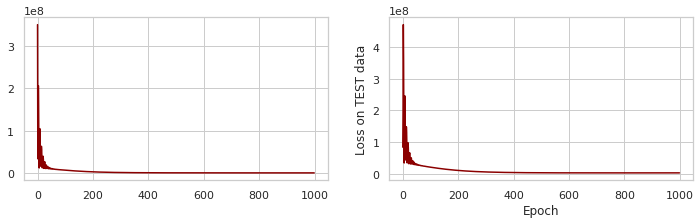

Epoch: 2
Learning rate: 0.007
Last loss on TRAIN data: 677742.4               Last loss on TEST data: 2294417.2


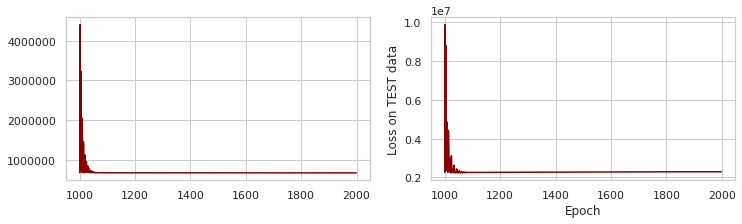

Epoch: 3
Learning rate: 0.007
Last loss on TRAIN data: 677711.44               Last loss on TEST data: 2292511.0


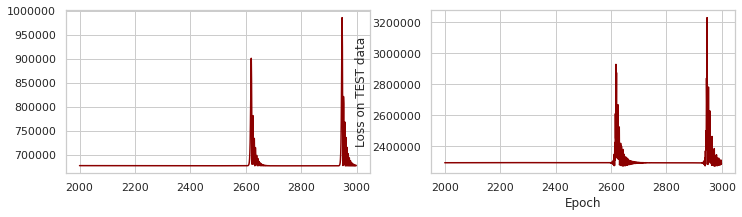

Epoch: 4
Learning rate: 0.007
Last loss on TRAIN data: 677145.06               Last loss on TEST data: 2284195.0


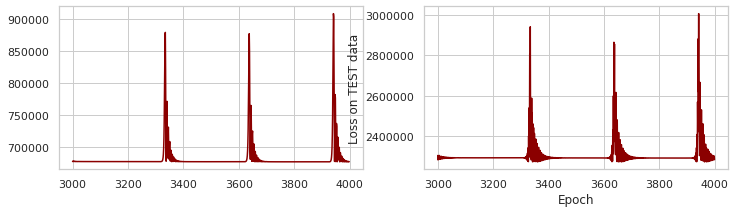

Epoch: 5
Learning rate: 0.007
Last loss on TRAIN data: 676208.9               Last loss on TEST data: 2297790.8


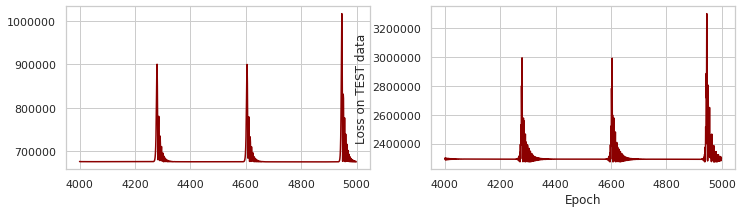

Epoch: 6
Learning rate: 0.007
Last loss on TRAIN data: 675600.7               Last loss on TEST data: 2289233.2


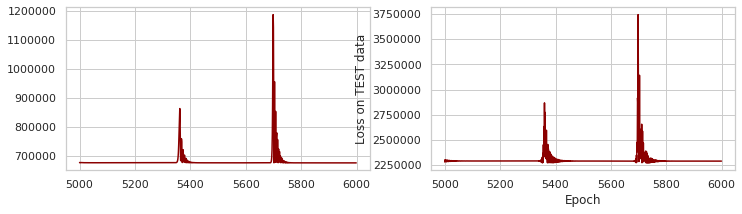

Epoch: 7
Learning rate: 0.007
Last loss on TRAIN data: 675069.06               Last loss on TEST data: 2287913.0


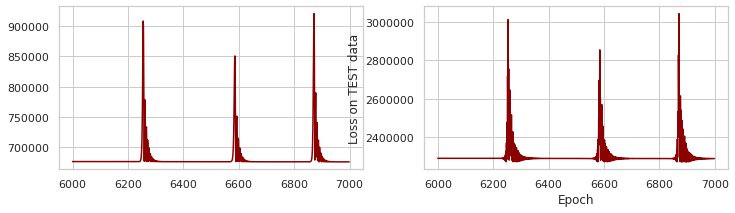

Epoch: 8
Learning rate: 0.007
Last loss on TRAIN data: 674540.56               Last loss on TEST data: 2285999.0


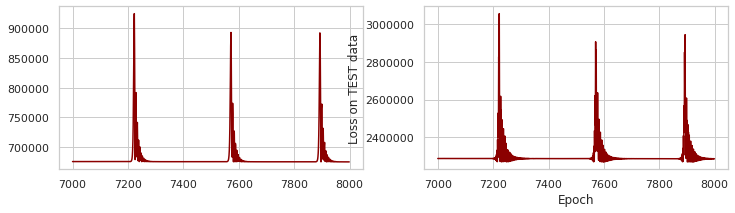

Epoch: 9
Learning rate: 0.007
Last loss on TRAIN data: 674014.44               Last loss on TEST data: 2285154.2


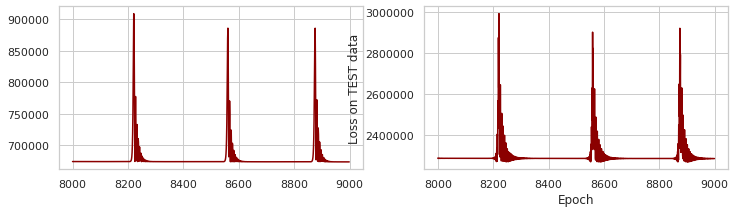

Epoch: 10
Learning rate: 0.007
Last loss on TRAIN data: 675672.56               Last loss on TEST data: 2287359.2


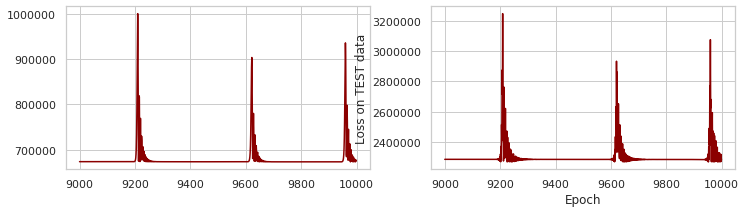

Epoch: 11
Learning rate: 0.007
Last loss on TRAIN data: 673209.06               Last loss on TEST data: 2286108.8


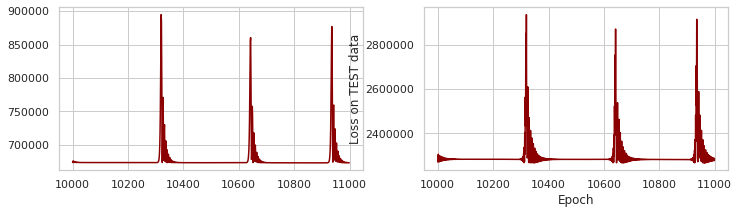

Epoch: 12
Learning rate: 0.007
Last loss on TRAIN data: 672495.94               Last loss on TEST data: 2280301.2


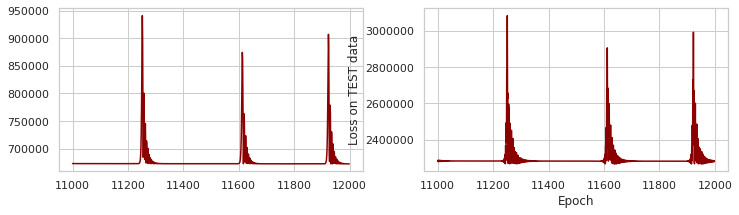

Epoch: 13
Learning rate: 0.007
Last loss on TRAIN data: 671940.25               Last loss on TEST data: 2279424.8


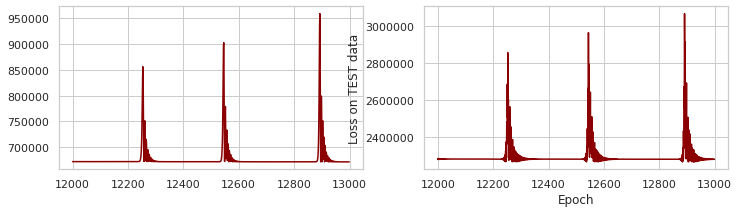

Epoch: 14
Learning rate: 0.007
Last loss on TRAIN data: 671544.8               Last loss on TEST data: 2278382.8


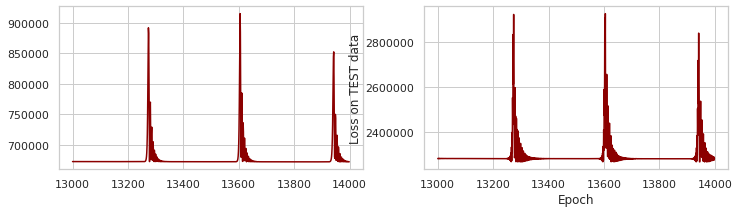

In [17]:
# fix the random seed
SEED = 42
random_init(SEED)

# initialization model, loss function, optimizator
model = Model_1(len(features),1)
loss_func = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=5e-2)

# set the epoch numbers, initialization list for every loss after learning on epoch
epochs = 15000
losses_train = []
losses_test = []
# initialization counter for calculation epoch numbers
counter = 0
# start the learning model
for epoch in range(epochs):
    model.train()
#     make prediction targets on train data
    y_pred_train = model(torch.tensor(X_train.to_numpy(), dtype=torch.float))
#     calculate loss
    loss = loss_func(y_pred_train, 
                     torch.reshape(torch.tensor(y_train.to_numpy(), dtype=torch.float),(-1,1)))
#     bacward loss to model and calculate new parameters (coefficients) with fixed learning rate
    loss.backward()
    opt.step()
    opt.zero_grad()

# add loss to list losses 
    losses_train.append(loss)
    
    model.eval()
    y_pred_test = model(torch.tensor(X_test.to_numpy(), dtype=torch.float))
    loss_test = loss_func(y_pred_test, 
                     torch.reshape(torch.tensor(y_test.to_numpy(), dtype=torch.float),(-1,1)))
    losses_test.append(loss_test)
    
    
# make the mini report for every 1000 epoch    
    if epoch % 1000 == 0 and epoch > 0:
        print ('Epoch:', epoch // 1000)
        print ('Learning rate:', opt.param_groups[0]['lr'])
        print ('Last loss on TRAIN data:', losses_train[-1].cpu().detach().numpy(),
              '              Last loss on TEST data:', losses_test[-1].cpu().detach().numpy())
#         print ('Last loss on TEST data:', losses_test[-1].cpu().detach().numpy())
        fig, (ax1, ax2) = plt.subplots(1, 2)
#         fig.suptitle('MSE on TRAIN & TEST DATA')
        fig.set_figheight(3)
        fig.set_figwidth(12)
        ax1.plot(np.arange(counter,epoch,1), np.array([float(i) for i in losses_train][-1000:]), color = 'darkred')
        plt.xlabel("Epoch")
        plt.ylabel("Loss on TRAIN data")
        ax2.plot(np.arange(counter,epoch,1), np.array([float(i) for i in losses_test][-1000:]), color = 'darkred')
        plt.xlabel("Epoch")
        plt.ylabel("Loss on TEST data")
        plt.show()
        
        counter += 1000
        
#   reduce learning rate
    if epoch == 1000:
        opt = torch.optim.Adam(model.parameters(), lr=7e-3)
        


REPORT - ORIGINAL VALUES

Model Model_1(
  (linear): Linear(in_features=12, out_features=1, bias=True)
)
Features ['Target_(t - 1)', 'Target_(t - 2)', 'Target_(t - 3)', 'Target_(t - 4)', 'Target_(t - 5)', 'Target_(t - 6)', 'Target_(t - 7)', 'Target_(t - 8)', 'Target_(t - 9)', 'Target_(t - 10)', 'Target_(t - 11)', 'Target_(t - 12)']

TRAIN PERIOD: 2010-01-01 00:00:00 2018-12-01 00:00:00 



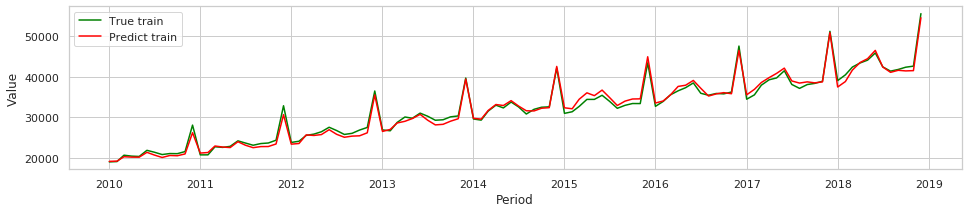

Average value: 31982, RMSE: 819, 2.561167% (RMSE/AVG)
Coefficient of determination: 0.9884


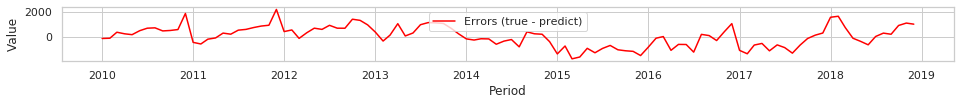

Остатки модели смещены на 51.7
Смещение составляет 0.16% от среднего значения прогнозируемой величины в 31930.6
Критерий Дики-Фуллера: p=0.0008578586287769131

TEST PERIOD: 2019-01-01 00:00:00 2020-12-01 00:00:00 



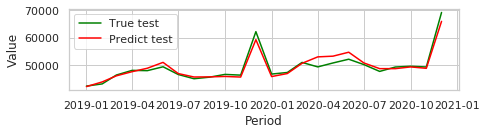

Average value: 49218, RMSE: 1509, 3.067201% (RMSE/AVG)
Coefficient of determination: 0.9273


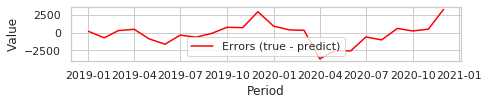

Остатки модели смещены на -127.53
Смещение составляет -0.26% от среднего значения прогнозируемой величины в 49345.7
Критерий Дики-Фуллера: p=0.2787626623867575

TRAIN + TEST + FORECAST: 2019-01-01 00:00:00 2021-12-01 00:00:00 



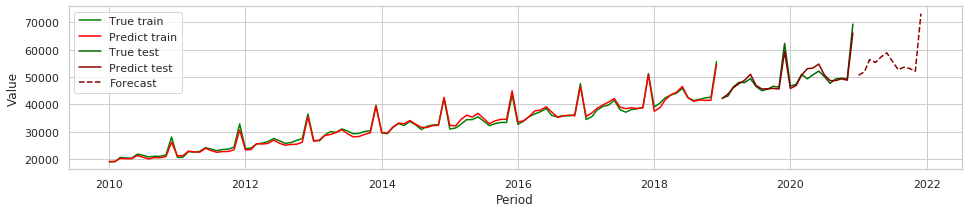

Coefficients values


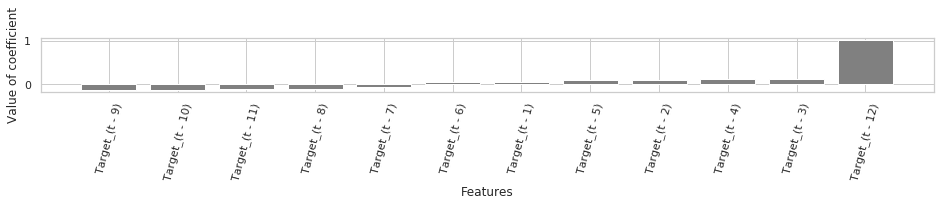

In [18]:
# create predict for train & test
predict_train = model(torch.tensor(X_train.to_numpy(), dtype=torch.float)).cpu().detach().numpy()
predict_test = model(torch.tensor(X_test.to_numpy(), dtype=torch.float)).cpu().detach().numpy()

# create forecasts
# select params
length_frcst = frcst_period.shape[0]
exogenous_features = exogenous_features
col_exgns_featrs = col_exgns_featrs
data = Xy[Xy['Split']=='Forecast'][Xy.columns[3:]]
model = model
# build the forecast
forecasts = make_forecast_NN(length_frcst, exogenous_features, col_exgns_featrs, data, model)

# check the quality of the model on the training and test set, build a forecast

# select the params
name_report = 'ORIGINAL VALUES'
true_train, true_test = y_train, y_test
predict_train, predict_test, forecast = predict_train, predict_test, forecasts
train_period, test_period, forecast_period = trn_period, tst_period, frcst_period
model = model
features = Xy.columns[3:].to_list()
graph_train = True
graph_test = True
graph_forecast = True
graph_coef = True
size_graph_1_1, size_graph_1_2, size_graph_2_1, size_graph_2_2, size_graph_3, size_graph_4 = \
    (16,3), (16,1), (7,1.5), (7,1), (16,3), (16,1)

MODEL, RMSE, CoefDetrmntn, AVG, PERCENTS = make_report_NN(name_report, 
                true_train, true_test, predict_train, predict_test, forecast, 
                train_period, test_period, forecast_period, 
                model, features, graph_train, graph_test, graph_forecast, graph_coef,
                size_graph_1_1, size_graph_1_2, size_graph_2_1, size_graph_2_2, size_graph_3, size_graph_4)

### Save statistics from model and check it

In [19]:
# initialization data frame
model_columns = ['Model', 'Model_name', 'RMSE', 'Coef_DetRMNTN', 'AVG', 'PERCENTS']
model_statistics = pd.DataFrame(columns=model_columns)
st_counter = 0

In [20]:
# add row to data frame 
MODEL_NAME = 'time-series only'
statistics = [MODEL, MODEL_NAME, RMSE, CoefDetrmntn, AVG, PERCENTS]
st_counter += 1

model_statistics.loc[st_counter] = statistics

report_pivot_model_statistics(model_statistics, train_period, test_period, forecast_period)


PIVOT TABLE "Multyple model statistics" on TEST DATA

Periods:
  - train:     2010-01-01 00:00:00 - 2018-12-01 00:00:00
  - test:      2019-01-01 00:00:00 - 2020-12-01 00:00:00
  - forecast:  2021-01-01 00:00:00 - 2021-12-01 00:00:00


,Model,Model_name,RMSE,Coef_DetRMNTN,AVG,PERCENTS
1,"Model_1(\n (linear): Linear(in_features=12, o...",time-series only,1509.62,0.9273,49218.17,3.0672


# Create dataset - 24 past raw time-series with exogenous

In [21]:
# create Xy

# select params
data_ts, data_ex = timeseries_data, exogen_TS_data
exogenous_features = True
col_period, col_target, col_split = 'Period', 'Values', 'Split'
col_exgns_featrs = exogen_TS_data.columns[2:]
shifts = np.arange(1, 13, 1) # select period in past to predict target value

# use function to create Xy
Xy = create_Xy(data_ts, data_ex, exogenous_features,
              col_period,col_target,col_split,col_exgns_featrs, shifts)

Xy.head(2)

,Period,Split,Target,Target_(t - 1),Target_(t - 2),Target_(t - 3),Target_(t - 4),Target_(t - 5),Target_(t - 6),Target_(t - 7),...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
204,2010-01-01,Train,18938.0,24004.0,19215.0,18798.0,18838.0,18335.0,18872.0,19247.0,...,0,0,0,0,0,0,0,0,0,0
205,2010-02-01,Train,19017.0,18938.0,24004.0,19215.0,18798.0,18838.0,18335.0,18872.0,...,0,0,0,0,0,0,0,0,0,0


## Modeling and check results

In [22]:
# split Xy to train, test & forecast
# select params
data = Xy
features = Xy.columns[3:]
# split
X_train, y_train, X_test, y_test, X_forecast = split_Xy(data, features)

Epoch: 1
Learning rate: 0.05
Last loss on TRAIN data: 661793.2               Last loss on TEST data: 2254327.2


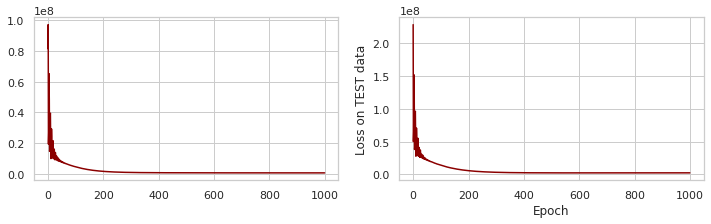

Epoch: 2
Learning rate: 0.007
Last loss on TRAIN data: 650543.9               Last loss on TEST data: 2254551.2


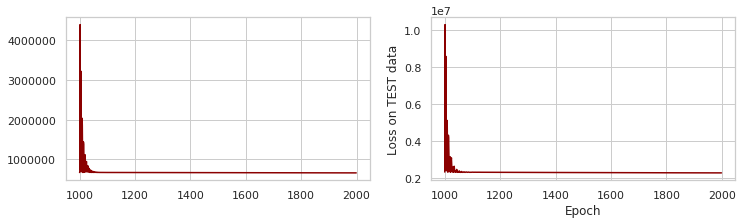

Epoch: 3
Learning rate: 0.007
Last loss on TRAIN data: 635138.4               Last loss on TEST data: 2232549.2


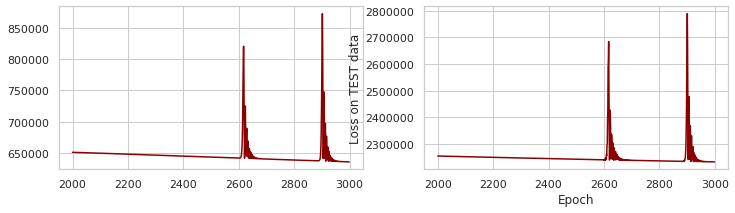

Epoch: 4
Learning rate: 0.007
Last loss on TRAIN data: 621349.5               Last loss on TEST data: 2218485.2


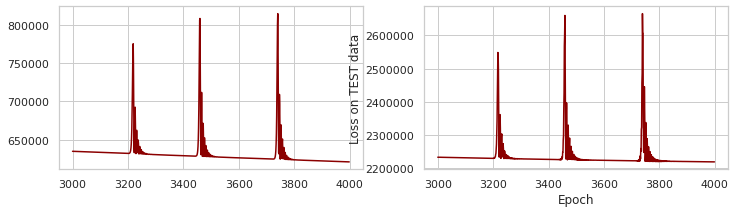

Epoch: 5
Learning rate: 0.007
Last loss on TRAIN data: 609642.25               Last loss on TEST data: 2212303.0


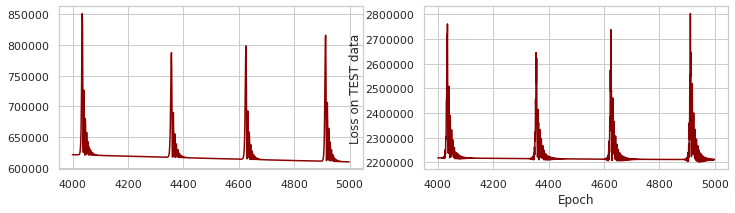

Epoch: 6
Learning rate: 0.007
Last loss on TRAIN data: 599646.3               Last loss on TEST data: 2209344.0


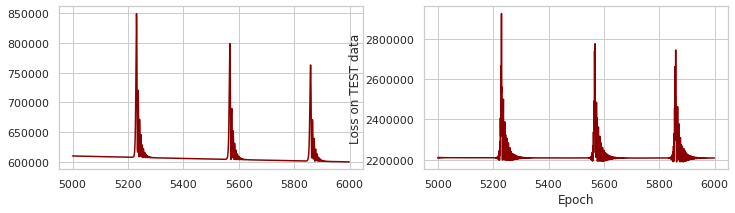

Epoch: 7
Learning rate: 0.007
Last loss on TRAIN data: 591092.0               Last loss on TEST data: 2216813.2


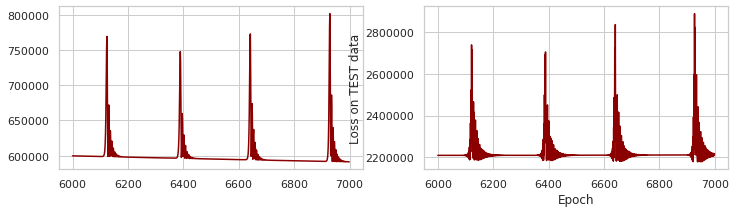

Epoch: 8
Learning rate: 0.007
Last loss on TRAIN data: 583740.5               Last loss on TEST data: 2217096.2


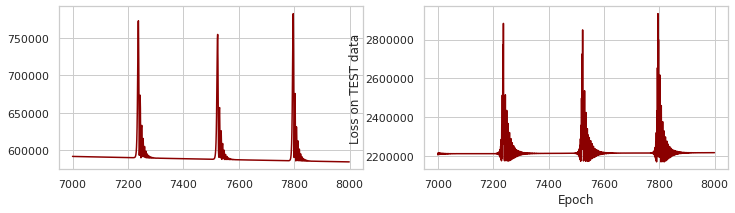

Epoch: 9
Learning rate: 0.007
Last loss on TRAIN data: 577419.3               Last loss on TEST data: 2225154.5


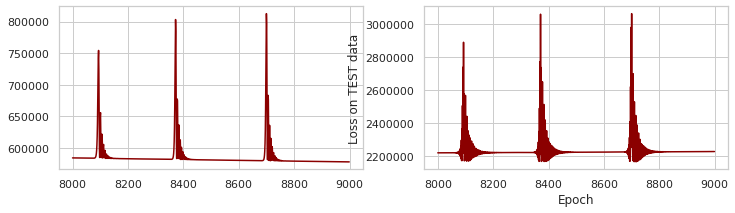

Epoch: 10
Learning rate: 0.007
Last loss on TRAIN data: 571913.75               Last loss on TEST data: 2234434.5


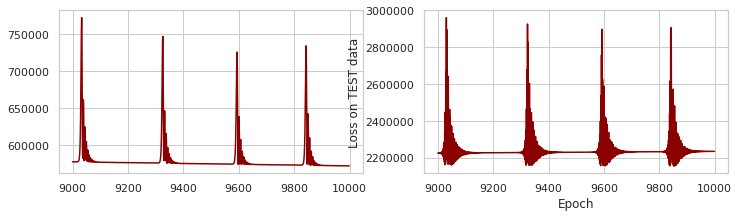

Epoch: 11
Learning rate: 0.007
Last loss on TRAIN data: 567068.06               Last loss on TEST data: 2244191.8


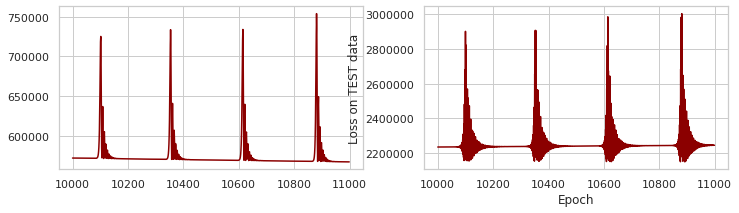

Epoch: 12
Learning rate: 0.007
Last loss on TRAIN data: 567884.5               Last loss on TEST data: 2183093.8


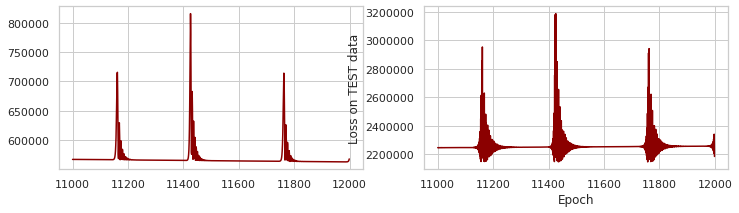

Epoch: 13
Learning rate: 0.007
Last loss on TRAIN data: 558877.3               Last loss on TEST data: 2266985.2


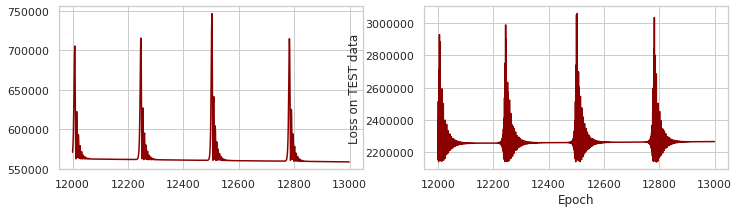

Epoch: 14
Learning rate: 0.007
Last loss on TRAIN data: 555335.8               Last loss on TEST data: 2278135.2


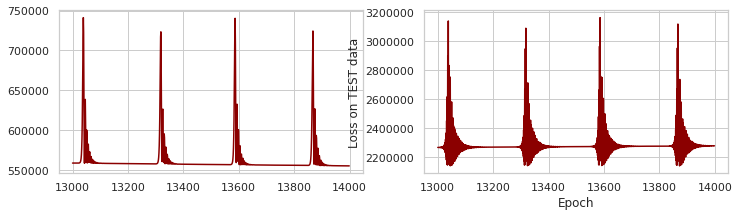

In [23]:
# fix the random seed
SEED = 42
random_init(SEED)

# initialization model, loss function, optimizator
model = Model_1(len(features),1)
loss_func = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=5e-2)

# set the epoch numbers, initialization list for every loss after learning on epoch
epochs = 15000
losses_train = []
losses_test = []
# initialization counter for calculation epoch numbers
counter = 0
# start the learning model
for epoch in range(epochs):
    model.train()
#     make prediction targets on train data
    y_pred_train = model(torch.tensor(X_train.to_numpy(), dtype=torch.float))
#     calculate loss
    loss = loss_func(y_pred_train, 
                     torch.reshape(torch.tensor(y_train.to_numpy(), dtype=torch.float),(-1,1)))
#     bacward loss to model and calculate new parameters (coefficients) with fixed learning rate
    loss.backward()
    opt.step()
    opt.zero_grad()

# add loss to list losses 
    losses_train.append(loss)
    
    model.eval()
    y_pred_test = model(torch.tensor(X_test.to_numpy(), dtype=torch.float))
    loss_test = loss_func(y_pred_test, 
                     torch.reshape(torch.tensor(y_test.to_numpy(), dtype=torch.float),(-1,1)))
    losses_test.append(loss_test)
    
    
# make the mini report for every 1000 epoch    
    if epoch % 1000 == 0 and epoch > 0:
        print ('Epoch:', epoch // 1000)
        print ('Learning rate:', opt.param_groups[0]['lr'])
        print ('Last loss on TRAIN data:', losses_train[-1].cpu().detach().numpy(),
              '              Last loss on TEST data:', losses_test[-1].cpu().detach().numpy())
#         print ('Last loss on TEST data:', losses_test[-1].cpu().detach().numpy())
        fig, (ax1, ax2) = plt.subplots(1, 2)
#         fig.suptitle('MSE on TRAIN & TEST DATA')
        fig.set_figheight(3)
        fig.set_figwidth(12)
        ax1.plot(np.arange(counter,epoch,1), np.array([float(i) for i in losses_train][-1000:]), color = 'darkred')
        plt.xlabel("Epoch")
        plt.ylabel("Loss on TRAIN data")
        ax2.plot(np.arange(counter,epoch,1), np.array([float(i) for i in losses_test][-1000:]), color = 'darkred')
        plt.xlabel("Epoch")
        plt.ylabel("Loss on TEST data")
        plt.show()
        
        counter += 1000
        
#   reduce learning rate
    if epoch == 1000:
        opt = torch.optim.Adam(model.parameters(), lr=7e-3)
        


REPORT - ORIGINAL VALUES

Model Model_1(
  (linear): Linear(in_features=25, out_features=1, bias=True)
)
Features ['Target_(t - 1)', 'Target_(t - 2)', 'Target_(t - 3)', 'Target_(t - 4)', 'Target_(t - 5)', 'Target_(t - 6)', 'Target_(t - 7)', 'Target_(t - 8)', 'Target_(t - 9)', 'Target_(t - 10)', 'Target_(t - 11)', 'Target_(t - 12)', 'Days_in_month', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']

TRAIN PERIOD: 2010-01-01 00:00:00 2018-12-01 00:00:00 



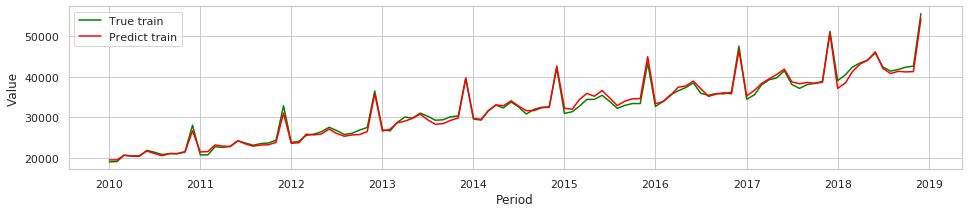

Average value: 31982, RMSE: 743, 2.323223% (RMSE/AVG)
Coefficient of determination: 0.9905


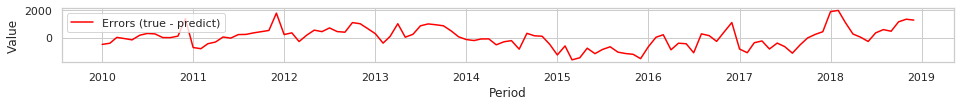

Остатки модели смещены на 12.82
Смещение составляет 0.04% от среднего значения прогнозируемой величины в 31969.47
Критерий Дики-Фуллера: p=0.0003098106410084741

TEST PERIOD: 2019-01-01 00:00:00 2020-12-01 00:00:00 



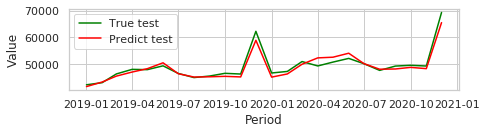

Average value: 49218, RMSE: 1514, 3.077481% (RMSE/AVG)
Coefficient of determination: 0.9268


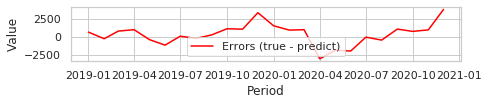

Остатки модели смещены на 391.07
Смещение составляет 0.8% от среднего значения прогнозируемой величины в 48827.1
Критерий Дики-Фуллера: p=0.23124162096282944

TRAIN + TEST + FORECAST: 2019-01-01 00:00:00 2021-12-01 00:00:00 



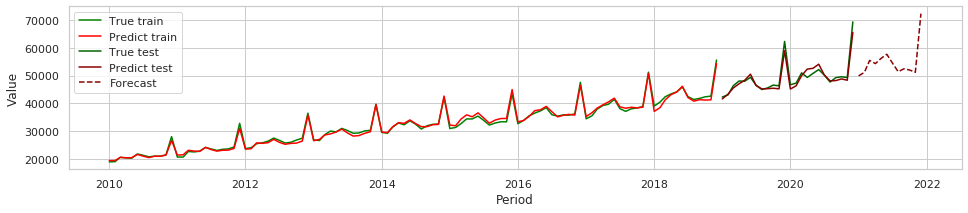

Coefficients values


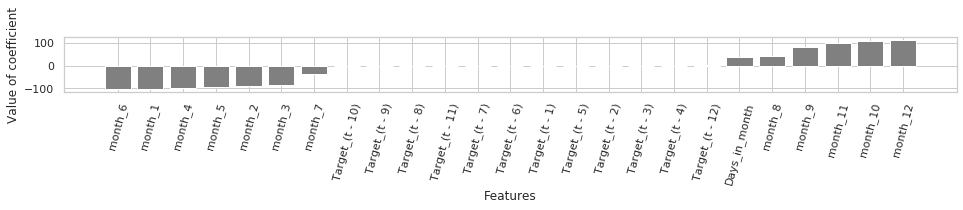

In [24]:
# create predict for train & test
predict_train = model(torch.tensor(X_train.to_numpy(), dtype=torch.float)).cpu().detach().numpy()
predict_test = model(torch.tensor(X_test.to_numpy(), dtype=torch.float)).cpu().detach().numpy()

# create forecasts
# select params
length_frcst = frcst_period.shape[0]
exogenous_features = exogenous_features
col_exgns_featrs = col_exgns_featrs
data = Xy[Xy['Split']=='Forecast'][Xy.columns[3:]]
model = model
# build the forecast
forecasts = make_forecast_NN(length_frcst, exogenous_features, col_exgns_featrs, data, model)

# check the quality of the model on the training and test set, build a forecast

# select the params
name_report = 'ORIGINAL VALUES'
true_train, true_test = y_train, y_test
predict_train, predict_test, forecast = predict_train, predict_test, forecasts
train_period, test_period, forecast_period = trn_period, tst_period, frcst_period
model = model
features = Xy.columns[3:].to_list()
graph_train = True
graph_test = True
graph_forecast = True
graph_coef = True
size_graph_1_1, size_graph_1_2, size_graph_2_1, size_graph_2_2, size_graph_3, size_graph_4 = \
    (16,3), (16,1), (7,1.5), (7,1), (16,3), (16,1)

MODEL, RMSE, CoefDetrmntn, AVG, PERCENTS = make_report_NN(name_report, 
                true_train, true_test, predict_train, predict_test, forecast, 
                train_period, test_period, forecast_period, 
                model, features, graph_train, graph_test, graph_forecast, graph_coef,
                size_graph_1_1, size_graph_1_2, size_graph_2_1, size_graph_2_2, size_graph_3, size_graph_4)

### Save statistics from model and check it

In [25]:
# add row to data frame 
MODEL_NAME = 'time-series with exogenous features'
statistics = [MODEL, MODEL_NAME, RMSE, CoefDetrmntn, AVG, PERCENTS]
st_counter += 1

model_statistics.loc[st_counter] = statistics

report_pivot_model_statistics(model_statistics, train_period, test_period, forecast_period)


PIVOT TABLE "Multyple model statistics" on TEST DATA

Periods:
  - train:     2010-01-01 00:00:00 - 2018-12-01 00:00:00
  - test:      2019-01-01 00:00:00 - 2020-12-01 00:00:00
  - forecast:  2021-01-01 00:00:00 - 2021-12-01 00:00:00


,Model,Model_name,RMSE,Coef_DetRMNTN,AVG,PERCENTS
1,"Model_1(\n (linear): Linear(in_features=12, o...",time-series only,1509.62,0.9273,49218.17,3.0672
2,"Model_1(\n (linear): Linear(in_features=25, o...",time-series with exogenous features,1514.68,0.9268,49218.17,3.0775


# Getting rid of heteroscedasticity - logarithm the time series

In [26]:
# logarithm the time series
timeseries_data['log_Values'] = np.log(timeseries_data['Values'])
timeseries_data[240:252]

,Period,Values,Split,log_Values
240,2013-01-01,26840.0,Train,10.197649
241,2013-02-01,26620.0,Train,10.189418
242,2013-03-01,28693.0,Train,10.264408
243,2013-04-01,30026.0,Train,10.309819
244,2013-05-01,29723.0,Train,10.299676
245,2013-06-01,30986.0,Train,10.341291
246,2013-07-01,30229.0,Train,10.316557
247,2013-08-01,29226.0,Train,10.282814
248,2013-09-01,29346.0,Train,10.286912
249,2013-10-01,30069.0,Train,10.311250


# Create dataset - 24 past logarithm time-series with exogenous features

In [27]:
# create Xy

# select params
data_ts, data_ex = timeseries_data, exogen_TS_data
exogenous_features = True
col_period, col_target, col_split = 'Period', 'log_Values', 'Split'
col_exgns_featrs = exogen_TS_data.columns[2:]
shifts = np.arange(1, 13, 1) # select period in past to predict target value

# use function to create Xy
Xy = create_Xy(data_ts, data_ex, exogenous_features,
              col_period,col_target,col_split,col_exgns_featrs, shifts)

Xy.head(2)

,Period,Split,Target,Target_(t - 1),Target_(t - 2),Target_(t - 3),Target_(t - 4),Target_(t - 5),Target_(t - 6),Target_(t - 7),...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
204,2010-01-01,Train,9.848926,10.085976,9.863447,9.841506,9.843631,9.816567,9.845435,9.865110,...,0,0,0,0,0,0,0,0,0,0
205,2010-02-01,Train,9.853089,9.848926,10.085976,9.863447,9.841506,9.843631,9.816567,9.845435,...,0,0,0,0,0,0,0,0,0,0


## Modeling and check results

### **check the predicts logarithm time series**

In [28]:
# split Xy to train, test & forecast
# select params
data = Xy
features = Xy.columns[3:]
# split
X_train, y_train, X_test, y_test, X_forecast = split_Xy(data, features)

Epoch: 1
Learning rate: 0.05
Last loss on TRAIN data: 0.00080239703               Last loss on TEST data: 0.003339032


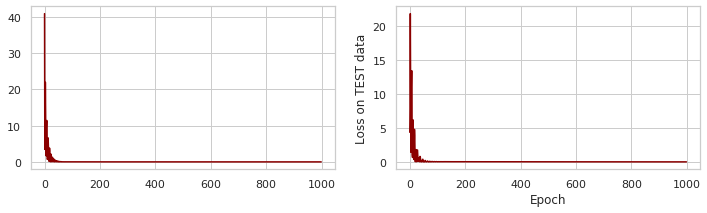

Epoch: 2
Learning rate: 0.007
Last loss on TRAIN data: 0.00029780634               Last loss on TEST data: 0.0006276409


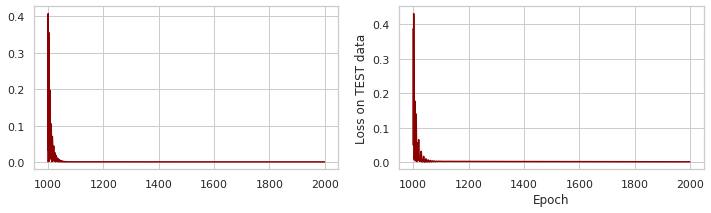

Epoch: 3
Learning rate: 0.007
Last loss on TRAIN data: 0.0002873676               Last loss on TEST data: 0.00047451942


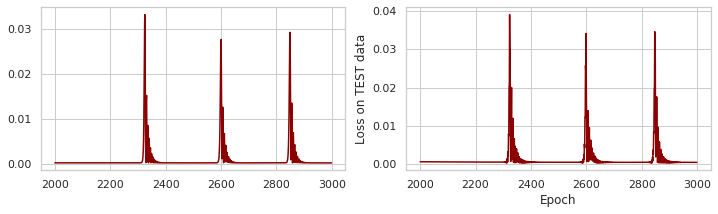

Epoch: 4
Learning rate: 0.007
Last loss on TRAIN data: 0.013599582               Last loss on TEST data: 0.012431259


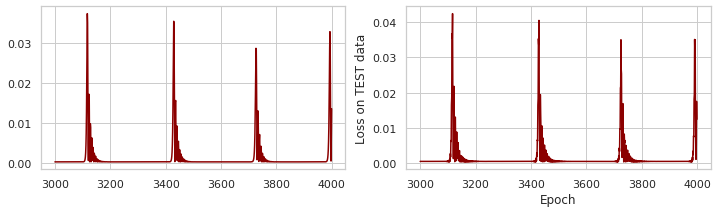

Epoch: 5
Learning rate: 0.007
Last loss on TRAIN data: 0.0002829168               Last loss on TEST data: 0.0004683327


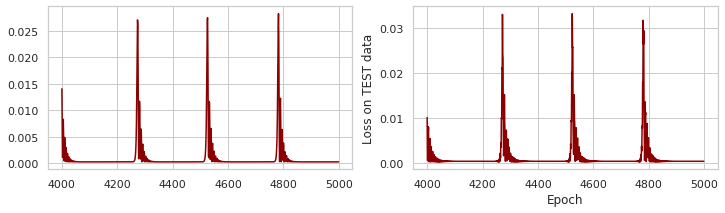

Epoch: 6
Learning rate: 0.007
Last loss on TRAIN data: 0.0002809948               Last loss on TEST data: 0.00045873286


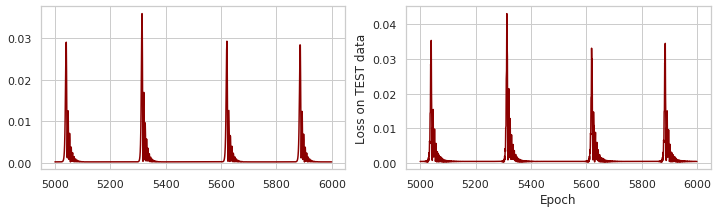

Epoch: 7
Learning rate: 0.007
Last loss on TRAIN data: 0.007284827               Last loss on TEST data: 0.0045936657


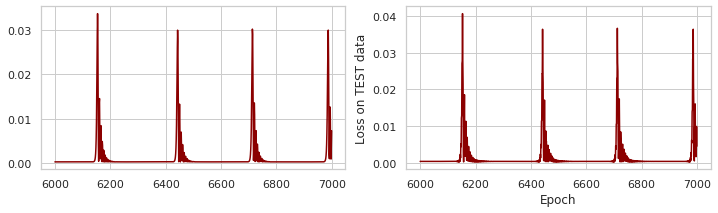

Epoch: 8
Learning rate: 0.007
Last loss on TRAIN data: 0.0002767753               Last loss on TEST data: 0.0004679691


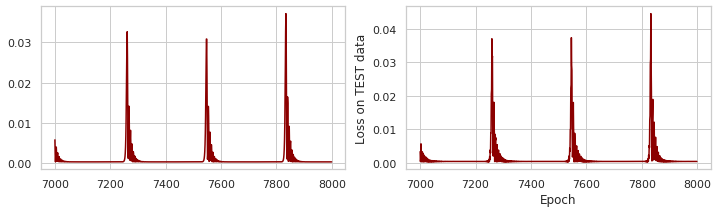

Epoch: 9
Learning rate: 0.007
Last loss on TRAIN data: 0.0005507916               Last loss on TEST data: 0.0012744194


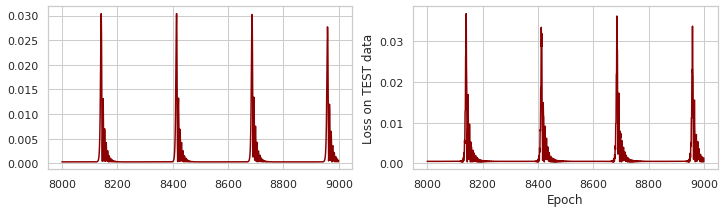

Epoch: 10
Learning rate: 0.007
Last loss on TRAIN data: 0.00027296992               Last loss on TEST data: 0.00046854766


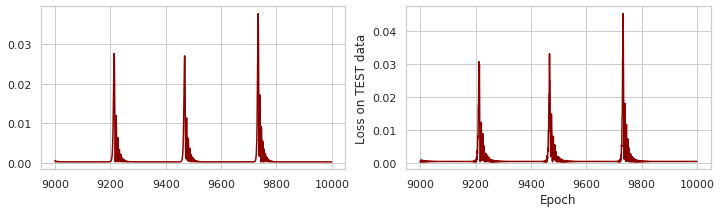

Epoch: 11
Learning rate: 0.007
Last loss on TRAIN data: 0.0002711657               Last loss on TEST data: 0.00046923113


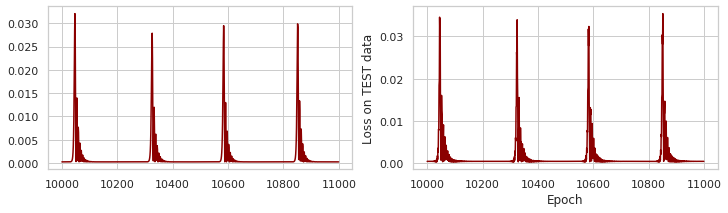

Epoch: 12
Learning rate: 0.007
Last loss on TRAIN data: 0.00027308404               Last loss on TEST data: 0.00044829445


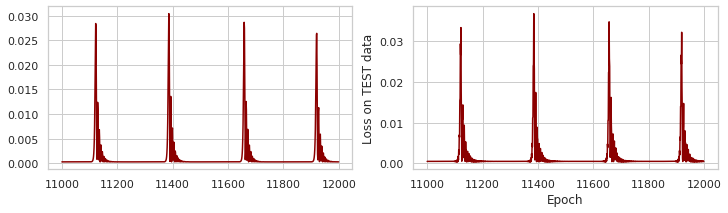

Epoch: 13
Learning rate: 0.007
Last loss on TRAIN data: 0.0002679112               Last loss on TEST data: 0.00048100334


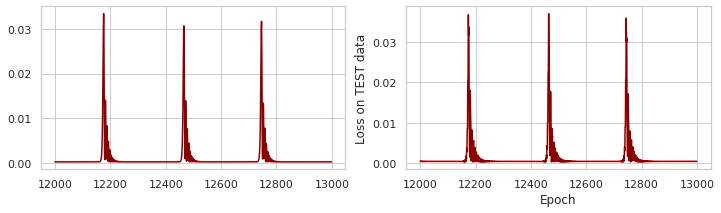

Epoch: 14
Learning rate: 0.007
Last loss on TRAIN data: 0.0002699206               Last loss on TEST data: 0.00042735497


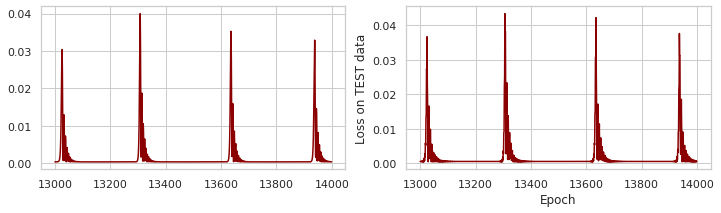

In [29]:
# fix the random seed
SEED = 42
random_init(SEED)

# initialization model, loss function, optimizator
model = Model_1(len(features),1)
loss_func = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=5e-2)

# set the epoch numbers, initialization list for every loss after learning on epoch
epochs = 15000
losses_train = []
losses_test = []
# initialization counter for calculation epoch numbers
counter = 0
# start the learning model
for epoch in range(epochs):
    model.train()
#     make prediction targets on train data
    y_pred_train = model(torch.tensor(X_train.to_numpy(), dtype=torch.float))
#     calculate loss
    loss = loss_func(y_pred_train, 
                     torch.reshape(torch.tensor(y_train.to_numpy(), dtype=torch.float),(-1,1)))
#     bacward loss to model and calculate new parameters (coefficients) with fixed learning rate
    loss.backward()
    opt.step()
    opt.zero_grad()

# add loss to list losses 
    losses_train.append(loss)
    
    model.eval()
    y_pred_test = model(torch.tensor(X_test.to_numpy(), dtype=torch.float))
    loss_test = loss_func(y_pred_test, 
                     torch.reshape(torch.tensor(y_test.to_numpy(), dtype=torch.float),(-1,1)))
    losses_test.append(loss_test)
    
    
# make the mini report for every 1000 epoch    
    if epoch % 1000 == 0 and epoch > 0:
        print ('Epoch:', epoch // 1000)
        print ('Learning rate:', opt.param_groups[0]['lr'])
        print ('Last loss on TRAIN data:', losses_train[-1].cpu().detach().numpy(),
              '              Last loss on TEST data:', losses_test[-1].cpu().detach().numpy())
#         print ('Last loss on TEST data:', losses_test[-1].cpu().detach().numpy())
        fig, (ax1, ax2) = plt.subplots(1, 2)
#         fig.suptitle('MSE on TRAIN & TEST DATA')
        fig.set_figheight(3)
        fig.set_figwidth(12)
        ax1.plot(np.arange(counter,epoch,1), np.array([float(i) for i in losses_train][-1000:]), color = 'darkred')
        plt.xlabel("Epoch")
        plt.ylabel("Loss on TRAIN data")
        ax2.plot(np.arange(counter,epoch,1), np.array([float(i) for i in losses_test][-1000:]), color = 'darkred')
        plt.xlabel("Epoch")
        plt.ylabel("Loss on TEST data")
        plt.show()
        
        counter += 1000
        
#   reduce learning rate
    if epoch == 1000:
        opt = torch.optim.Adam(model.parameters(), lr=7e-3)
        


REPORT - ORIGINAL VALUES

Model Model_1(
  (linear): Linear(in_features=25, out_features=1, bias=True)
)
Features ['Target_(t - 1)', 'Target_(t - 2)', 'Target_(t - 3)', 'Target_(t - 4)', 'Target_(t - 5)', 'Target_(t - 6)', 'Target_(t - 7)', 'Target_(t - 8)', 'Target_(t - 9)', 'Target_(t - 10)', 'Target_(t - 11)', 'Target_(t - 12)', 'Days_in_month', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']

TRAIN PERIOD: 2010-01-01 00:00:00 2018-12-01 00:00:00 



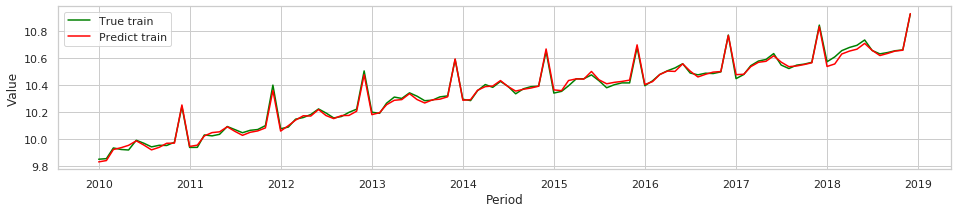

Average value: 10, RMSE: 0, 0.193424% (RMSE/AVG)
Coefficient of determination: 0.9953


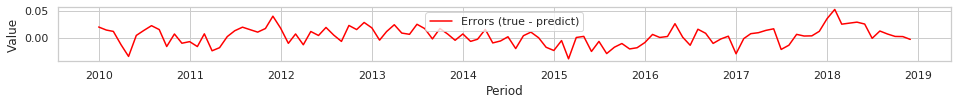

Остатки модели смещены на 0.0
Смещение составляет 0.03% от среднего значения прогнозируемой величины в 10.34
Критерий Дики-Фуллера: p=0.0044953905390864345

TEST PERIOD: 2019-01-01 00:00:00 2020-12-01 00:00:00 



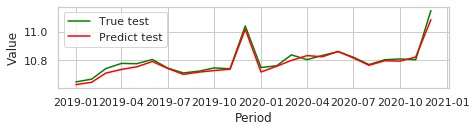

Average value: 10, RMSE: 0, 0.185185% (RMSE/AVG)
Coefficient of determination: 0.948


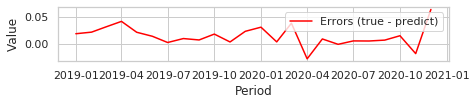

Остатки модели смещены на 0.01
Смещение составляет 0.13% от среднего значения прогнозируемой величины в 10.78
Критерий Дики-Фуллера: p=0.9840915099776444

TRAIN + TEST + FORECAST: 2019-01-01 00:00:00 2021-12-01 00:00:00 



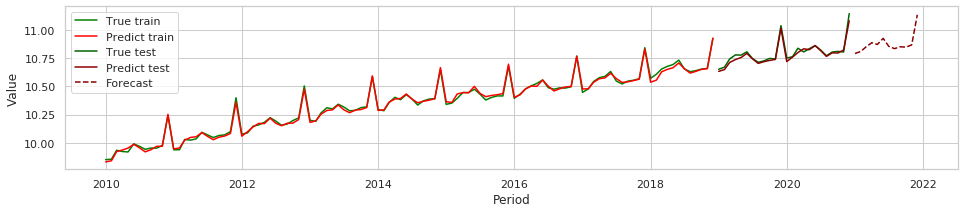

Coefficients values


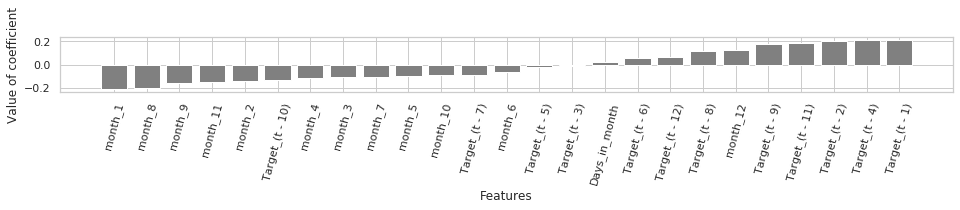

In [30]:
# create predict for train & test
predict_train = model(torch.tensor(X_train.to_numpy(), dtype=torch.float)).cpu().detach().numpy()
predict_test = model(torch.tensor(X_test.to_numpy(), dtype=torch.float)).cpu().detach().numpy()

# create forecasts
# select params
length_frcst = frcst_period.shape[0]
exogenous_features = exogenous_features
col_exgns_featrs = col_exgns_featrs
data = Xy[Xy['Split']=='Forecast'][Xy.columns[3:]]
model = model
# build the forecast
forecasts = make_forecast_NN(length_frcst, exogenous_features, col_exgns_featrs, data, model)

# check the quality of the model on the training and test set, build a forecast

# select the params
name_report = 'ORIGINAL VALUES'
true_train, true_test = y_train, y_test
predict_train, predict_test, forecast = predict_train, predict_test, forecasts
train_period, test_period, forecast_period = trn_period, tst_period, frcst_period
model = model
features = Xy.columns[3:].to_list()
graph_train = True
graph_test = True
graph_forecast = True
graph_coef = True
size_graph_1_1, size_graph_1_2, size_graph_2_1, size_graph_2_2, size_graph_3, size_graph_4 = \
    (16,3), (16,1), (7,1.5), (7,1), (16,3), (16,1)

MODEL, RMSE, CoefDetrmntn, AVG, PERCENTS = make_report_NN(name_report, 
                true_train, true_test, predict_train, predict_test, forecast, 
                train_period, test_period, forecast_period, 
                model, features, graph_train, graph_test, graph_forecast, graph_coef,
                size_graph_1_1, size_graph_1_2, size_graph_2_1, size_graph_2_2, size_graph_3, size_graph_4)

### **check the predicts of inverse logarithm time series**


REPORT - ORIGINAL VALUES BEFORE LOGARITHM

Model Model_1(
  (linear): Linear(in_features=25, out_features=1, bias=True)
)
Features ['Target_(t - 1)', 'Target_(t - 2)', 'Target_(t - 3)', 'Target_(t - 4)', 'Target_(t - 5)', 'Target_(t - 6)', 'Target_(t - 7)', 'Target_(t - 8)', 'Target_(t - 9)', 'Target_(t - 10)', 'Target_(t - 11)', 'Target_(t - 12)', 'Days_in_month', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']

TRAIN PERIOD: 2010-01-01 00:00:00 2018-12-01 00:00:00 



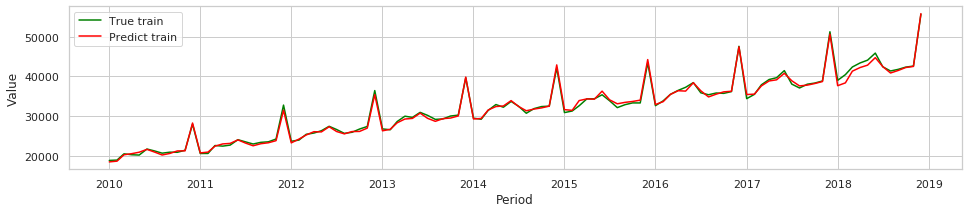

Average value: 31982, RMSE: 553, 1.731020% (RMSE/AVG)
Coefficient of determination: 0.9947


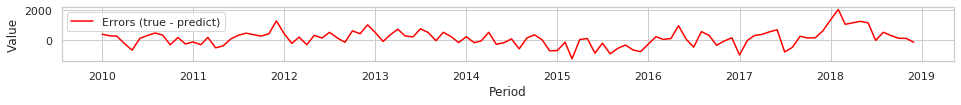

Остатки модели смещены на 104.25
Смещение составляет 0.33% от среднего значения прогнозируемой величины в 31878.05
Критерий Дики-Фуллера: p=0.022727301726571232

TEST PERIOD: 2019-01-01 00:00:00 2020-12-01 00:00:00 



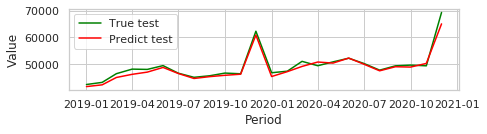

Average value: 49218, RMSE: 1282, 2.606456% (RMSE/AVG)
Coefficient of determination: 0.9475


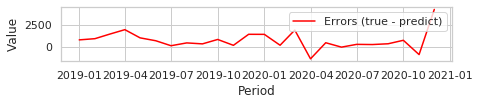

Остатки модели смещены на 729.93
Смещение составляет 1.51% от среднего значения прогнозируемой величины в 48488.24
Критерий Дики-Фуллера: p=0.9615576152244676

TRAIN + TEST + FORECAST: 2019-01-01 00:00:00 2021-12-01 00:00:00 



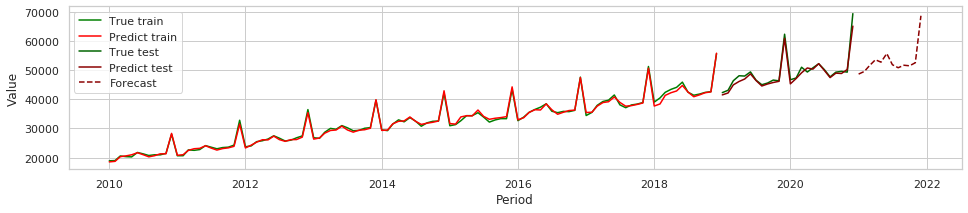

In [31]:
# data inverse of logarithm
predict_train_unlog = invboxcox(predict_train,lmbda=0)
predict_test_unlog = invboxcox(predict_test,lmbda=0)
forecast_unlog = invboxcox(forecast,lmbda=0)


# check the quality of the model on the training and test set, build a forecast

# select the params
name_report = 'ORIGINAL VALUES BEFORE LOGARITHM'
true_train = pd.DataFrame(timeseries_data['Values'][timeseries_data['Split']=='Train'])
true_test = pd.DataFrame(timeseries_data['Values'][timeseries_data['Split']=='Test'])
train_period, test_period, forecast_period = trn_period, tst_period, frcst_period
model = model
features = Xy.columns[3:].to_list()
graph_train = True
graph_test = True
graph_forecast = True
graph_coef = False
size_graph_1_1, size_graph_1_2, size_graph_2_1, size_graph_2_2, size_graph_3, size_graph_4 = \
    (16,3), (16,1), (7,1.5), (7,1), (16,3), (16,1)

MODEL, RMSE, CoefDetrmntn, AVG, PERCENTS = make_report_NN(name_report, 
                true_train, true_test, predict_train_unlog, predict_test_unlog, forecast_unlog, 
                train_period, test_period, forecast_period, 
                model, features, graph_train, graph_test, graph_forecast, graph_coef,
                size_graph_1_1, size_graph_1_2, size_graph_2_1, size_graph_2_2, size_graph_3, size_graph_4)

### Save statistics from model and check it

In [32]:
# add row to data frame 
MODEL_NAME = 'logarithm time-series with exogenous features'
statistics = [MODEL, MODEL_NAME, RMSE, CoefDetrmntn, AVG, PERCENTS]
st_counter += 1

model_statistics.loc[st_counter] = statistics

report_pivot_model_statistics(model_statistics, train_period, test_period, forecast_period)


PIVOT TABLE "Multyple model statistics" on TEST DATA

Periods:
  - train:     2010-01-01 00:00:00 - 2018-12-01 00:00:00
  - test:      2019-01-01 00:00:00 - 2020-12-01 00:00:00
  - forecast:  2021-01-01 00:00:00 - 2021-12-01 00:00:00


,Model,Model_name,RMSE,Coef_DetRMNTN,AVG,PERCENTS
1,"Model_1(\n (linear): Linear(in_features=12, o...",time-series only,1509.62,0.9273,49218.17,3.0672
2,"Model_1(\n (linear): Linear(in_features=25, o...",time-series with exogenous features,1514.68,0.9268,49218.17,3.0775
3,"Model_1(\n (linear): Linear(in_features=25, o...",logarithm time-series with exogenous features,1282.85,0.9475,49218.17,2.6065


# Let us reduce the logarithmic time series to the stationary one

In [33]:
# build a stationary logarithm time-series
# make shift to 12 period ago (12 mounths ago)
timeseries_data['shift_12_log_Values'] = timeseries_data['log_Values'].shift(12)
timeseries_data['dif_12_log_Values'] = timeseries_data['log_Values'] - timeseries_data['shift_12_log_Values']

# make shift to 1 period ago 
timeseries_data['shift_1_12_log_Values'] = timeseries_data['dif_12_log_Values'].shift(1)
timeseries_data['dif_1_12_log_Values'] = timeseries_data['dif_12_log_Values'] - timeseries_data['shift_1_12_log_Values']
timeseries_data[240:252]

,Period,Values,Split,log_Values,shift_12_log_Values,dif_12_log_Values,shift_1_12_log_Values,dif_1_12_log_Values
240,2013-01-01,26840.0,Train,10.197649,10.075169,0.122479,0.105239,0.017241
241,2013-02-01,26620.0,Train,10.189418,10.087308,0.102110,0.122479,-0.020369
242,2013-03-01,28693.0,Train,10.264408,10.145924,0.118485,0.102110,0.016375
243,2013-04-01,30026.0,Train,10.309819,10.158130,0.151689,0.118485,0.033205
244,2013-05-01,29723.0,Train,10.299676,10.180551,0.119125,0.151689,-0.032564
245,2013-06-01,30986.0,Train,10.341291,10.221723,0.119568,0.119125,0.000442
246,2013-07-01,30229.0,Train,10.316557,10.191819,0.124738,0.119568,0.005170
247,2013-08-01,29226.0,Train,10.282814,10.154946,0.127868,0.124738,0.003130
248,2013-09-01,29346.0,Train,10.286912,10.165698,0.121214,0.127868,-0.006654
249,2013-10-01,30069.0,Train,10.311250,10.196269,0.114981,0.121214,-0.006233


Критерий Дики-Фуллера: p=0.000000


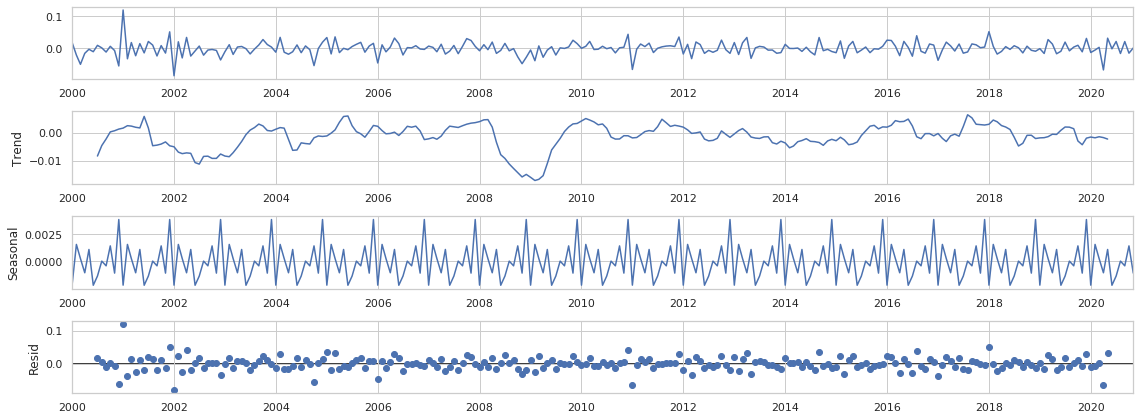

In [34]:
# make the charts
data = timeseries_data
x = 'Period'
y = 'dif_1_12_log_Values'
start = '2000-01-01'
stop = '2020-12-01'
size = (16,5)
color = 'darkblue'

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data[y][data[x]>=start][data[x]<stop])[1])
series = pd.Series(data[y][data[x]>=start][data[x]<stop].values,
                   index=data[x][data[x]>=start][data[x]<stop])
size = (16,6)
mpl.rc("figure", figsize=(size))
sm.tsa.seasonal_decompose(series).plot()
plt.show()

# Create dataset - stationary time series with exogenous features

In [35]:
# create Xy

# select params
data_ts, data_ex = timeseries_data, exogen_TS_data
exogenous_features = True
col_period, col_target, col_split = 'Period', 'dif_1_12_log_Values', 'Split'
col_exgns_featrs = exogen_TS_data.columns[2:]
shifts = np.arange(1, 2, 1) # select period in past to predict target value

# use function to create Xy
Xy = create_Xy(data_ts, data_ex, exogenous_features,
              col_period,col_target,col_split,col_exgns_featrs, shifts)

Xy.head(2)

,Period,Split,Target,Target_(t - 1),Days_in_month,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
204,2010-01-01,Train,-0.000803,0.013878,31,1,0,0,0,0,0,0,0,0,0,0,0
205,2010-02-01,Train,0.005390,-0.000803,28,0,1,0,0,0,0,0,0,0,0,0,0


## Modeling and check results

### **check the predicts stationary time series**

In [36]:
# split Xy to train, test & forecast
# select params
data = Xy
features = Xy.columns[3:]
# split
X_train, y_train, X_test, y_test, X_forecast = split_Xy(data, features)

Epoch: 1
Learning rate: 0.05
Last loss on TRAIN data: 0.00027104138               Last loss on TEST data: 0.00047526913


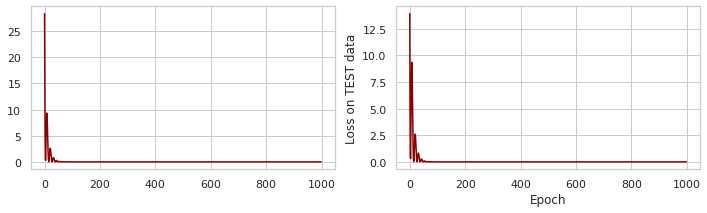

Epoch: 2
Learning rate: 0.007
Last loss on TRAIN data: 0.00027071984               Last loss on TEST data: 0.00047611856


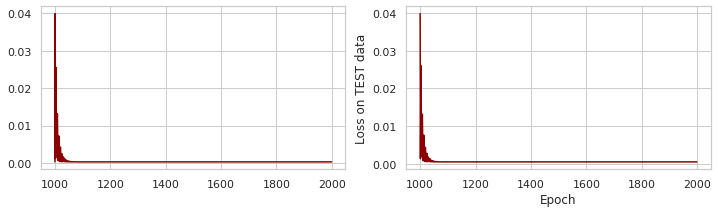

Epoch: 3
Learning rate: 0.007
Last loss on TRAIN data: 0.00027062872               Last loss on TEST data: 0.00047637487


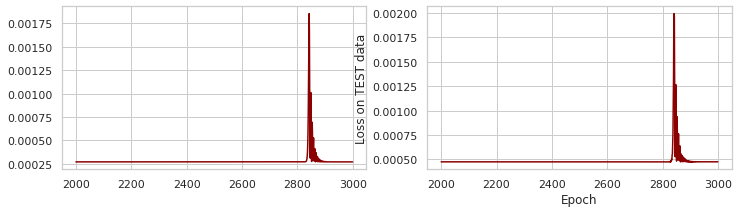

Epoch: 4
Learning rate: 0.007
Last loss on TRAIN data: 0.00027053073               Last loss on TEST data: 0.00047633264


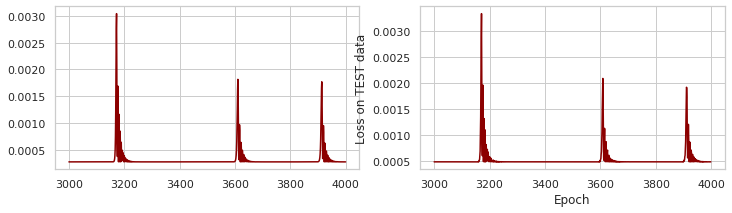

Epoch: 5
Learning rate: 0.007
Last loss on TRAIN data: 0.00027043646               Last loss on TEST data: 0.00047695413


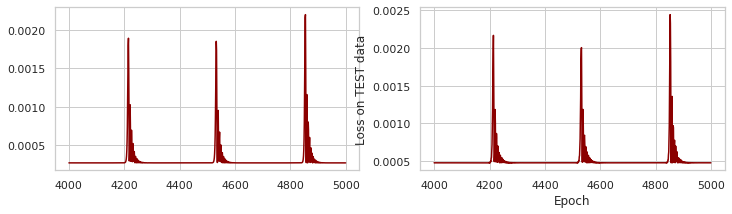

Epoch: 6
Learning rate: 0.007
Last loss on TRAIN data: 0.00027034915               Last loss on TEST data: 0.0004772586


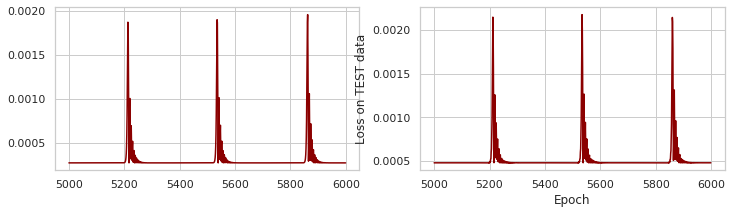

Epoch: 7
Learning rate: 0.007
Last loss on TRAIN data: 0.0002702664               Last loss on TEST data: 0.00047761947


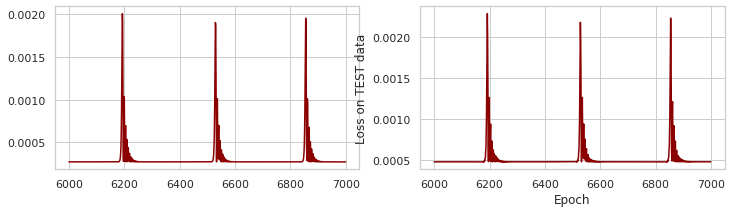

Epoch: 8
Learning rate: 0.007
Last loss on TRAIN data: 0.00027018847               Last loss on TEST data: 0.00047787023


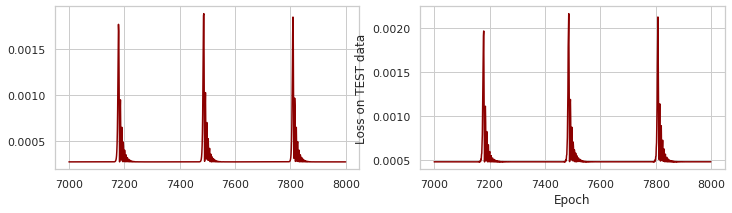

Epoch: 9
Learning rate: 0.007
Last loss on TRAIN data: 0.0002701163               Last loss on TEST data: 0.00047816485


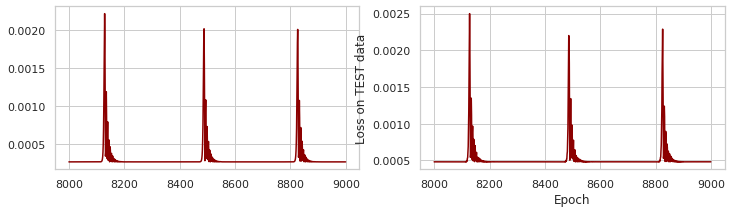

Epoch: 10
Learning rate: 0.007
Last loss on TRAIN data: 0.00027004868               Last loss on TEST data: 0.0004784357


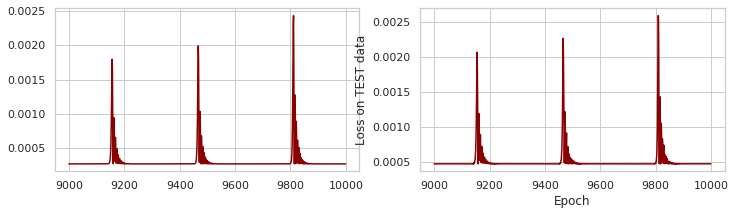

Epoch: 11
Learning rate: 0.007
Last loss on TRAIN data: 0.00027353305               Last loss on TEST data: 0.0004795608


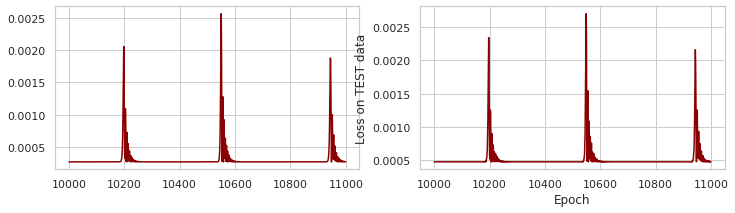

Epoch: 12
Learning rate: 0.007
Last loss on TRAIN data: 0.0002699266               Last loss on TEST data: 0.0004790382


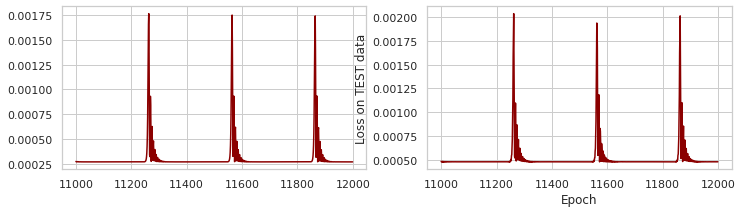

Epoch: 13
Learning rate: 0.007
Last loss on TRAIN data: 0.0002698696               Last loss on TEST data: 0.0004792513


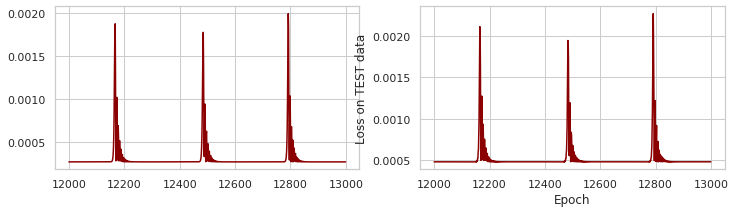

Epoch: 14
Learning rate: 0.007
Last loss on TRAIN data: 0.00026981713               Last loss on TEST data: 0.00047951014


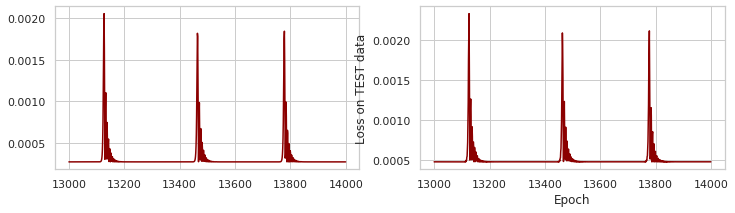

In [37]:
# fix the random seed
SEED = 42
random_init(SEED)

# initialization model, loss function, optimizator
model = Model_1(len(features),1)
loss_func = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=5e-2)

# set the epoch numbers, initialization list for every loss after learning on epoch
epochs = 15000
losses_train = []
losses_test = []
# initialization counter for calculation epoch numbers
counter = 0
# start the learning model
for epoch in range(epochs):
    model.train()
#     make prediction targets on train data
    y_pred_train = model(torch.tensor(X_train.to_numpy(), dtype=torch.float))
#     calculate loss
    loss = loss_func(y_pred_train, 
                     torch.reshape(torch.tensor(y_train.to_numpy(), dtype=torch.float),(-1,1)))
#     bacward loss to model and calculate new parameters (coefficients) with fixed learning rate
    loss.backward()
    opt.step()
    opt.zero_grad()

# add loss to list losses 
    losses_train.append(loss)
    
    model.eval()
    y_pred_test = model(torch.tensor(X_test.to_numpy(), dtype=torch.float))
    loss_test = loss_func(y_pred_test, 
                     torch.reshape(torch.tensor(y_test.to_numpy(), dtype=torch.float),(-1,1)))
    losses_test.append(loss_test)
    
    
# make the mini report for every 1000 epoch    
    if epoch % 1000 == 0 and epoch > 0:
        print ('Epoch:', epoch // 1000)
        print ('Learning rate:', opt.param_groups[0]['lr'])
        print ('Last loss on TRAIN data:', losses_train[-1].cpu().detach().numpy(),
              '              Last loss on TEST data:', losses_test[-1].cpu().detach().numpy())
#         print ('Last loss on TEST data:', losses_test[-1].cpu().detach().numpy())
        fig, (ax1, ax2) = plt.subplots(1, 2)
#         fig.suptitle('MSE on TRAIN & TEST DATA')
        fig.set_figheight(3)
        fig.set_figwidth(12)
        ax1.plot(np.arange(counter,epoch,1), np.array([float(i) for i in losses_train][-1000:]), color = 'darkred')
        plt.xlabel("Epoch")
        plt.ylabel("Loss on TRAIN data")
        ax2.plot(np.arange(counter,epoch,1), np.array([float(i) for i in losses_test][-1000:]), color = 'darkred')
        plt.xlabel("Epoch")
        plt.ylabel("Loss on TEST data")
        plt.show()
        
        counter += 1000
        
#   reduce learning rate
    if epoch == 1000:
        opt = torch.optim.Adam(model.parameters(), lr=7e-3)
        


REPORT - ORIGINAL VALUES

Model Model_1(
  (linear): Linear(in_features=14, out_features=1, bias=True)
)
Features ['Target_(t - 1)', 'Days_in_month', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']

TRAIN PERIOD: 2010-01-01 00:00:00 2018-12-01 00:00:00 



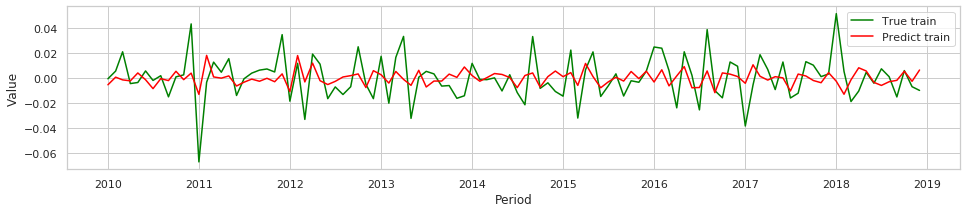

Average value: 0, RMSE: 0, -inf% (RMSE/AVG)
Coefficient of determination: 0.1154


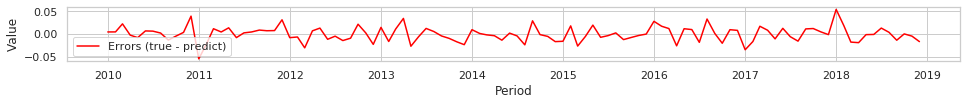

Остатки модели смещены на -0.0
Смещение составляет 2.31% от среднего значения прогнозируемой величины в -0.0
Критерий Дики-Фуллера: p=1.0257828798159593e-08

TEST PERIOD: 2019-01-01 00:00:00 2020-12-01 00:00:00 



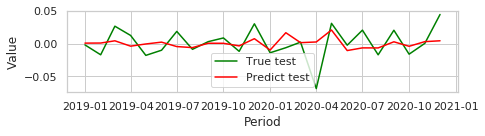

Average value: 0, RMSE: 0, inf% (RMSE/AVG)
Coefficient of determination: 0.077


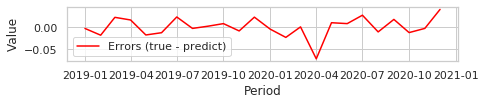

Остатки модели смещены на 0.0
Смещение составляет 135.52% от среднего значения прогнозируемой величины в 0.0
Критерий Дики-Фуллера: p=1.1687661548210752e-05

TRAIN + TEST + FORECAST: 2019-01-01 00:00:00 2021-12-01 00:00:00 



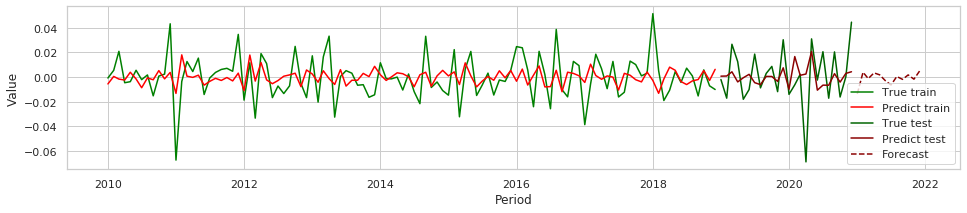

Coefficients values


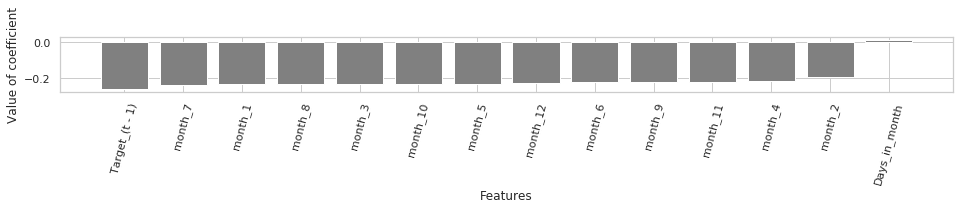

In [38]:
# create predict for train & test
predict_train = model(torch.tensor(X_train.to_numpy(), dtype=torch.float)).cpu().detach().numpy()
predict_test = model(torch.tensor(X_test.to_numpy(), dtype=torch.float)).cpu().detach().numpy()

# create forecasts
# select params
length_frcst = frcst_period.shape[0]
exogenous_features = exogenous_features
col_exgns_featrs = col_exgns_featrs
data = Xy[Xy['Split']=='Forecast'][Xy.columns[3:]]
model = model
# build the forecast
forecasts = make_forecast_NN(length_frcst, exogenous_features, col_exgns_featrs, data, model)

# check the quality of the model on the training and test set, build a forecast

# select the params
name_report = 'ORIGINAL VALUES'
true_train, true_test = y_train, y_test
predict_train, predict_test, forecast = predict_train, predict_test, forecasts
train_period, test_period, forecast_period = trn_period, tst_period, frcst_period
model = model
features = Xy.columns[3:].to_list()
graph_train = True
graph_test = True
graph_forecast = True
graph_coef = True
size_graph_1_1, size_graph_1_2, size_graph_2_1, size_graph_2_2, size_graph_3, size_graph_4 = \
    (16,3), (16,1), (7,1.5), (7,1), (16,3), (16,1)

MODEL, RMSE, CoefDetrmntn, AVG, PERCENTS = make_report_NN(name_report, 
                true_train, true_test, predict_train, predict_test, forecast, 
                train_period, test_period, forecast_period, 
                model, features, graph_train, graph_test, graph_forecast, graph_coef,
                size_graph_1_1, size_graph_1_2, size_graph_2_1, size_graph_2_2, size_graph_3, size_graph_4)

### **check the predicts of inverse stationary time series**

In [39]:
# inverse forecast from difference to logarithm values
forecast_data = pd.DataFrame()
forecast_data[timeseries_data.columns] = timeseries_data[timeseries_data['Split']=='Forecast']
forecast_data['dif_1_12_log_Values'] = forecast

counter = 0
for i in range(len(forecast)):

    forecast_data['dif_12_log_Values'][i:i+1] = \
        forecast_data['dif_1_12_log_Values'][i:i+1] + forecast_data['shift_1_12_log_Values'][i:i+1]

    forecast_data['log_Values'][i:i+1] = forecast_data['dif_12_log_Values'][i:i+1] + forecast_data['shift_12_log_Values'][i:i+1]
    counter +=1
    if counter >= len(forecast):
        break
    forecast_data['shift_1_12_log_Values'][i+1:i+2] = forecast_data['dif_12_log_Values'][i:i+1]


REPORT - ORIGINAL VALUES

Model Model_1(
  (linear): Linear(in_features=14, out_features=1, bias=True)
)
Features ['Target_(t - 1)', 'Days_in_month', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']

TRAIN PERIOD: 2010-01-01 00:00:00 2018-12-01 00:00:00 



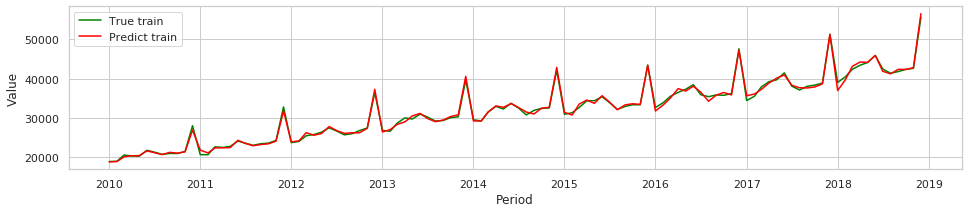

Average value: 31982, RMSE: 533, 1.667610% (RMSE/AVG)
Coefficient of determination: 0.9951


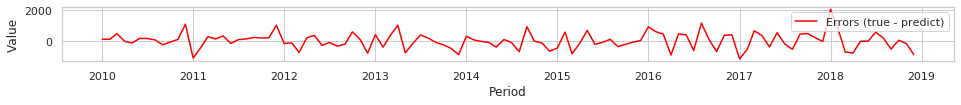

Остатки модели смещены на -5.85
Смещение составляет -0.02% от среднего значения прогнозируемой величины в 31988.15
Критерий Дики-Фуллера: p=2.8259679031905606e-17

TEST PERIOD: 2019-01-01 00:00:00 2020-12-01 00:00:00 



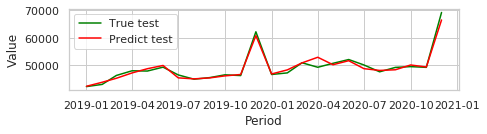

Average value: 49218, RMSE: 1163, 2.363172% (RMSE/AVG)
Coefficient of determination: 0.9568


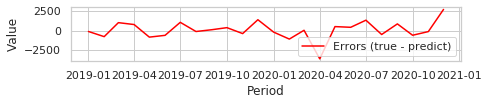

Остатки модели смещены на 68.9
Смещение составляет 0.14% от среднего значения прогнозируемой величины в 49149.27
Критерий Дики-Фуллера: p=4.475594854209665e-05

TRAIN + TEST + FORECAST: 2019-01-01 00:00:00 2021-12-01 00:00:00 



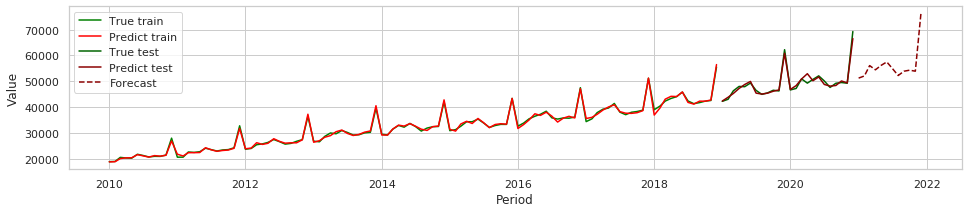

In [40]:
# data inverse of logarithm
inverse_train = predict_train + \
    timeseries_data['shift_1_12_log_Values'][timeseries_data['Split']=='Train'].to_numpy().reshape(-1,1)
inverse_train = inverse_train + \
    timeseries_data['shift_12_log_Values'][timeseries_data['Split']=='Train'].to_numpy().reshape(-1,1)
inverse_train = invboxcox(inverse_train, lmbda=0)

inverse_test = predict_test + \
    timeseries_data['shift_1_12_log_Values'][timeseries_data['Split']=='Test'].to_numpy().reshape(-1,1)
inverse_test = inverse_test + \
    timeseries_data['shift_12_log_Values'][timeseries_data['Split']=='Test'].to_numpy().reshape(-1,1)
inverse_test = invboxcox(inverse_test, lmbda=0)

forecast_unlog = invboxcox(forecast_data['log_Values'],lmbda=0)


# check the quality of the model on the training and test set, build a forecast

# select the params
name_report = 'ORIGINAL VALUES'
true_train = pd.DataFrame(timeseries_data['Values'][timeseries_data['Split']=='Train'])
true_test = pd.DataFrame(timeseries_data['Values'][timeseries_data['Split']=='Test'])
# predict_train, predict_test, forecast = predict_train_unlog, predict_test_unlog, forecast_unlog
train_period, test_period, forecast_period = trn_period, tst_period, frcst_period
model = model
features = Xy.columns[3:].to_list()
graph_train = True
graph_test = True
graph_forecast = True
graph_coef = False
size_graph_1_1, size_graph_1_2, size_graph_2_1, size_graph_2_2, size_graph_3, size_graph_4 = \
    (16,3), (16,1), (7,1.5), (7,1), (16,3), (16,1)

MODEL, RMSE, CoefDetrmntn, AVG, PERCENTS = make_report_NN(name_report, 
                true_train, true_test, inverse_train, inverse_test, forecast_unlog, 
                train_period, test_period, forecast_period, 
                model, features, graph_train, graph_test, graph_forecast, graph_coef,
                size_graph_1_1, size_graph_1_2, size_graph_2_1, size_graph_2_2, size_graph_3, size_graph_4)

### Save statistics from model and check it

In [41]:
# add row to data frame 
MODEL_NAME = 'stationary time-series with exogenous features'
statistics = [MODEL, MODEL_NAME, RMSE, CoefDetrmntn, AVG, PERCENTS]
st_counter += 1

model_statistics.loc[st_counter] = statistics

report_pivot_model_statistics(model_statistics, train_period, test_period, forecast_period)


PIVOT TABLE "Multyple model statistics" on TEST DATA

Periods:
  - train:     2010-01-01 00:00:00 - 2018-12-01 00:00:00
  - test:      2019-01-01 00:00:00 - 2020-12-01 00:00:00
  - forecast:  2021-01-01 00:00:00 - 2021-12-01 00:00:00


,Model,Model_name,RMSE,Coef_DetRMNTN,AVG,PERCENTS
1,"Model_1(\n (linear): Linear(in_features=12, o...",time-series only,1509.62,0.9273,49218.17,3.0672
2,"Model_1(\n (linear): Linear(in_features=25, o...",time-series with exogenous features,1514.68,0.9268,49218.17,3.0775
3,"Model_1(\n (linear): Linear(in_features=25, o...",logarithm time-series with exogenous features,1282.85,0.9475,49218.17,2.6065
4,"Model_1(\n (linear): Linear(in_features=14, o...",stationary time-series with exogenous features,1163.11,0.9568,49218.17,2.3632


# Create dataset - stationary time series only

In [42]:
# create Xy

# select params
data_ts, data_ex = timeseries_data, exogen_TS_data
exogenous_features = False
col_period, col_target, col_split = 'Period', 'dif_1_12_log_Values', 'Split'
col_exgns_featrs = exogen_TS_data.columns[2:]
shifts = np.arange(1, 2, 1) # select period in past to predict target value

# use function to create Xy
Xy = create_Xy(data_ts, data_ex, exogenous_features,
              col_period,col_target,col_split,col_exgns_featrs, shifts)

Xy.head(2)

,Period,Split,Target,Target_(t - 1)
204,2010-01-01,Train,-0.000803,0.013878
205,2010-02-01,Train,0.005390,-0.000803


## Modeling and check results

### **check the predicts stationary time series**

In [43]:
# split Xy to train, test & forecast
# select params
data = Xy
features = Xy.columns[3:]
# split
X_train, y_train, X_test, y_test, X_forecast = split_Xy(data, features)

Epoch: 1
Learning rate: 0.05
Last loss on TRAIN data: 0.00028429224               Last loss on TEST data: 0.00044883732


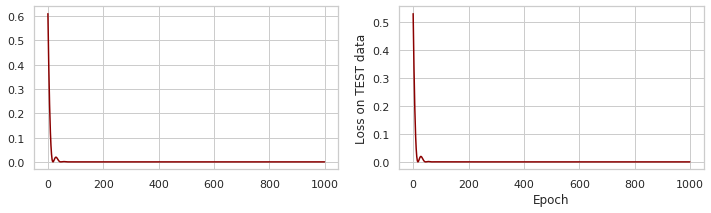

Epoch: 2
Learning rate: 0.007
Last loss on TRAIN data: 0.00028429224               Last loss on TEST data: 0.00044883732


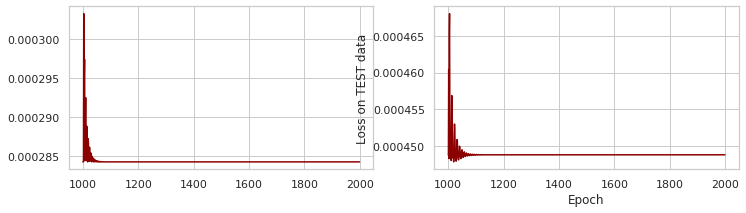

Epoch: 3
Learning rate: 0.007
Last loss on TRAIN data: 0.00028429224               Last loss on TEST data: 0.00044883732


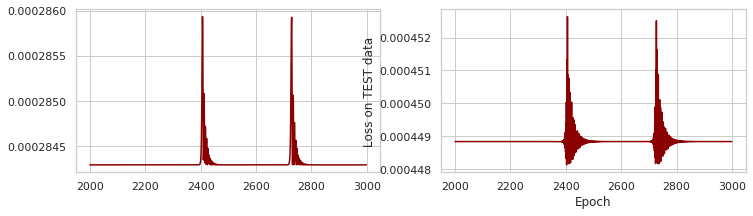

Epoch: 4
Learning rate: 0.007
Last loss on TRAIN data: 0.0002842922               Last loss on TEST data: 0.00044883732


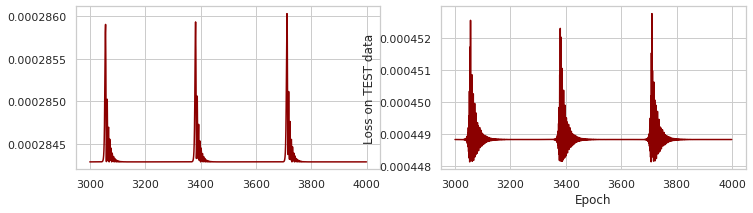

Epoch: 5
Learning rate: 0.007
Last loss on TRAIN data: 0.0002842922               Last loss on TEST data: 0.00044883636


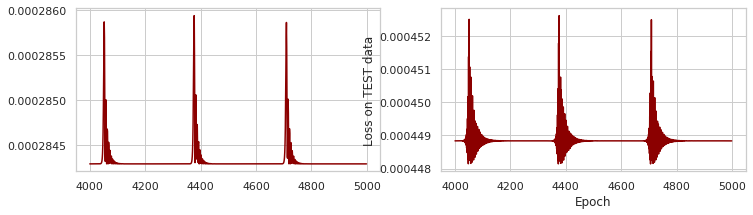

Epoch: 6
Learning rate: 0.007
Last loss on TRAIN data: 0.00028429224               Last loss on TEST data: 0.00044883927


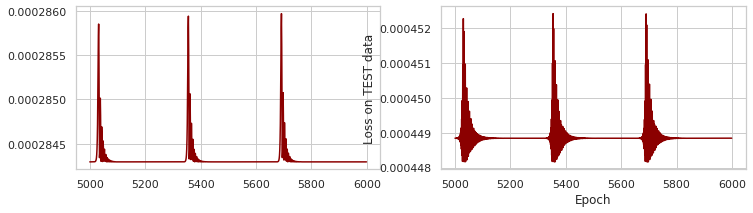

Epoch: 7
Learning rate: 0.007
Last loss on TRAIN data: 0.0002842922               Last loss on TEST data: 0.00044883727


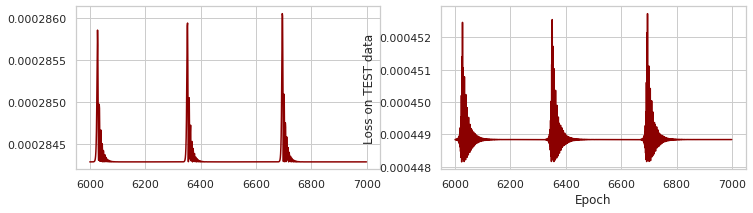

Epoch: 8
Learning rate: 0.007
Last loss on TRAIN data: 0.00028429224               Last loss on TEST data: 0.00044883732


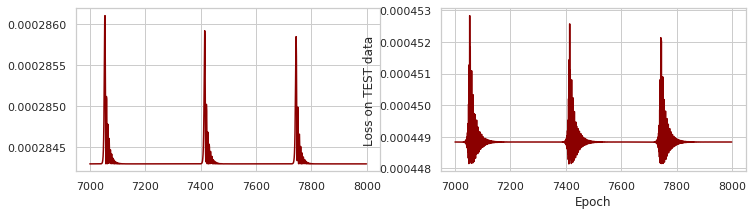

Epoch: 9
Learning rate: 0.007
Last loss on TRAIN data: 0.00028429224               Last loss on TEST data: 0.0004488373


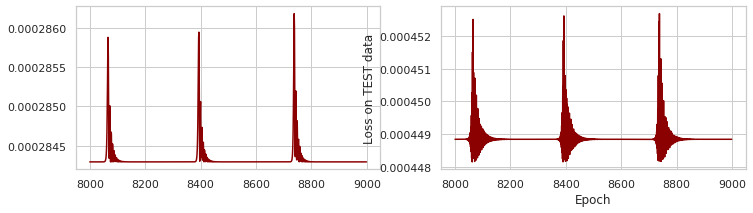

Epoch: 10
Learning rate: 0.007
Last loss on TRAIN data: 0.00028429224               Last loss on TEST data: 0.00044883727


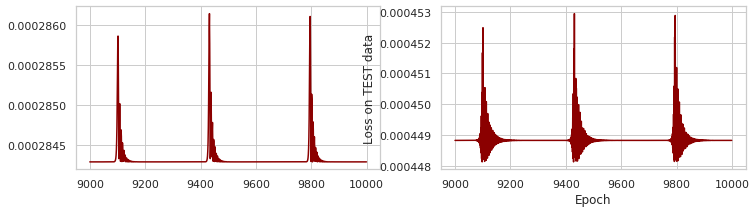

Epoch: 11
Learning rate: 0.007
Last loss on TRAIN data: 0.00028429224               Last loss on TEST data: 0.00044882877


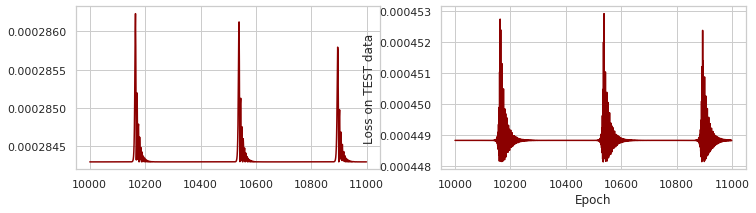

Epoch: 12
Learning rate: 0.007
Last loss on TRAIN data: 0.0002842924               Last loss on TEST data: 0.0004488281


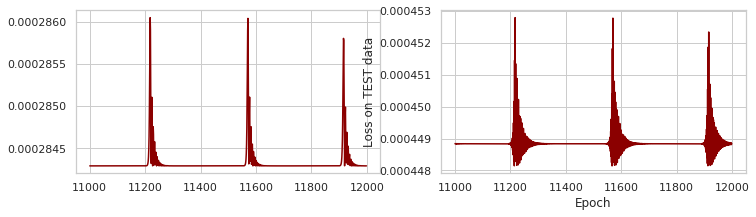

Epoch: 13
Learning rate: 0.007
Last loss on TRAIN data: 0.00028429425               Last loss on TEST data: 0.0004487949


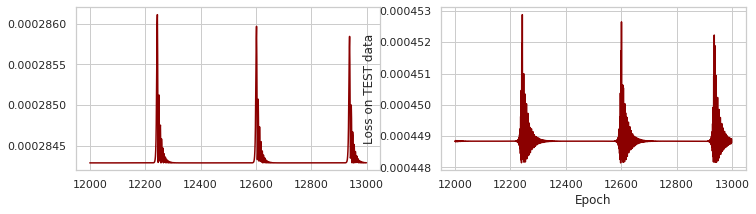

Epoch: 14
Learning rate: 0.007
Last loss on TRAIN data: 0.00028429236               Last loss on TEST data: 0.0004488288


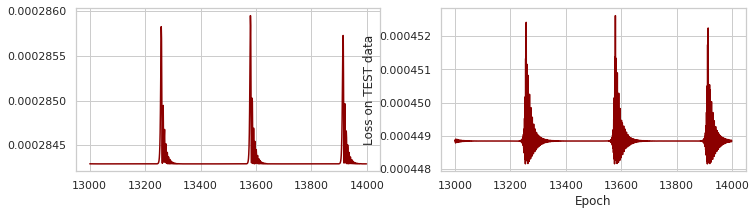

In [44]:
# fix the random seed
SEED = 42
random_init(SEED)

# initialization model, loss function, optimizator
model = Model_1(len(features),1)
loss_func = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=5e-2)

# set the epoch numbers, initialization list for every loss after learning on epoch
epochs = 15000
losses_train = []
losses_test = []
# initialization counter for calculation epoch numbers
counter = 0
# start the learning model
for epoch in range(epochs):
    model.train()
#     make prediction targets on train data
    y_pred_train = model(torch.tensor(X_train.to_numpy(), dtype=torch.float))
#     calculate loss
    loss = loss_func(y_pred_train, 
                     torch.reshape(torch.tensor(y_train.to_numpy(), dtype=torch.float),(-1,1)))
#     bacward loss to model and calculate new parameters (coefficients) with fixed learning rate
    loss.backward()
    opt.step()
    opt.zero_grad()

# add loss to list losses 
    losses_train.append(loss)
    
    model.eval()
    y_pred_test = model(torch.tensor(X_test.to_numpy(), dtype=torch.float))
    loss_test = loss_func(y_pred_test, 
                     torch.reshape(torch.tensor(y_test.to_numpy(), dtype=torch.float),(-1,1)))
    losses_test.append(loss_test)
    
    
# make the mini report for every 1000 epoch    
    if epoch % 1000 == 0 and epoch > 0:
        print ('Epoch:', epoch // 1000)
        print ('Learning rate:', opt.param_groups[0]['lr'])
        print ('Last loss on TRAIN data:', losses_train[-1].cpu().detach().numpy(),
              '              Last loss on TEST data:', losses_test[-1].cpu().detach().numpy())
#         print ('Last loss on TEST data:', losses_test[-1].cpu().detach().numpy())
        fig, (ax1, ax2) = plt.subplots(1, 2)
#         fig.suptitle('MSE on TRAIN & TEST DATA')
        fig.set_figheight(3)
        fig.set_figwidth(12)
        ax1.plot(np.arange(counter,epoch,1), np.array([float(i) for i in losses_train][-1000:]), color = 'darkred')
        plt.xlabel("Epoch")
        plt.ylabel("Loss on TRAIN data")
        ax2.plot(np.arange(counter,epoch,1), np.array([float(i) for i in losses_test][-1000:]), color = 'darkred')
        plt.xlabel("Epoch")
        plt.ylabel("Loss on TEST data")
        plt.show()
        
        counter += 1000
        
#   reduce learning rate
    if epoch == 1000:
        opt = torch.optim.Adam(model.parameters(), lr=7e-3)
        


REPORT - ORIGINAL VALUES

Model Model_1(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
Features ['Target_(t - 1)']

TRAIN PERIOD: 2010-01-01 00:00:00 2018-12-01 00:00:00 



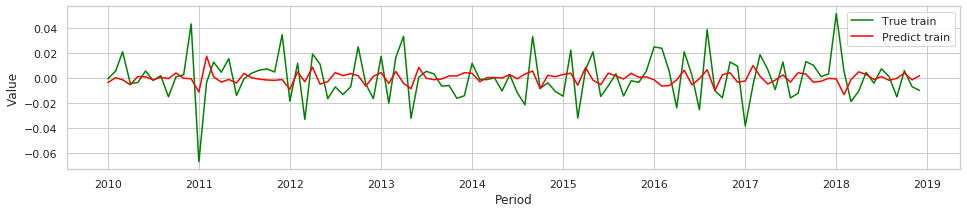

Average value: 0, RMSE: 0, -inf% (RMSE/AVG)
Coefficient of determination: 0.0678


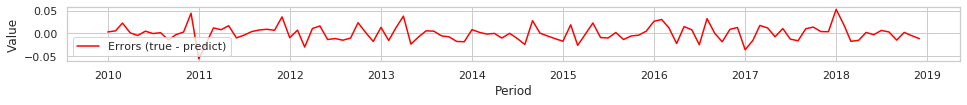

Остатки модели смещены на 0.0
Смещение составляет -1.44% от среднего значения прогнозируемой величины в -0.0
Критерий Дики-Фуллера: p=7.439658918095624e-17

TEST PERIOD: 2019-01-01 00:00:00 2020-12-01 00:00:00 



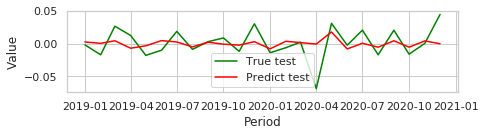

Average value: 0, RMSE: 0, inf% (RMSE/AVG)
Coefficient of determination: 0.1365


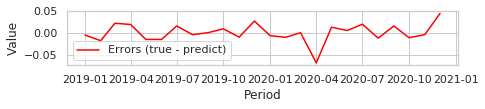

Остатки модели смещены на 0.0
Смещение составляет 633.17% от среднего значения прогнозируемой величины в 0.0
Критерий Дики-Фуллера: p=5.654568572230233e-06

TRAIN + TEST + FORECAST: 2019-01-01 00:00:00 2021-12-01 00:00:00 



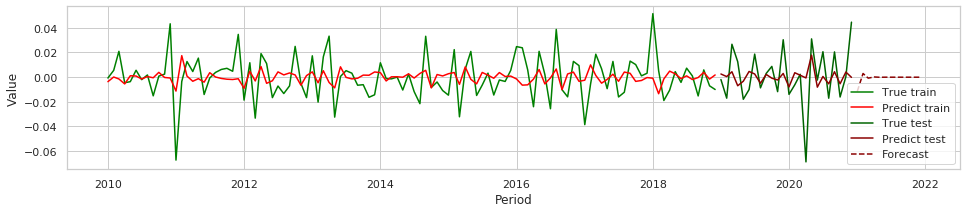

Coefficients values


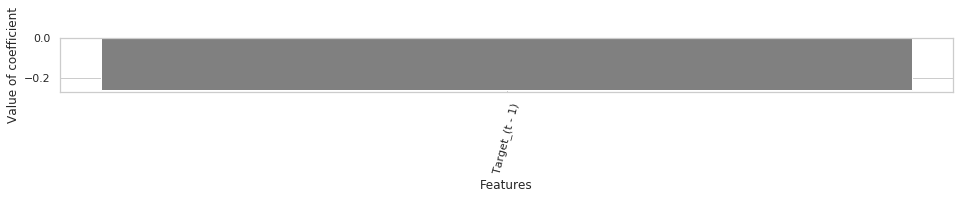

In [45]:
# create predict for train & test
predict_train = model(torch.tensor(X_train.to_numpy(), dtype=torch.float)).cpu().detach().numpy()
predict_test = model(torch.tensor(X_test.to_numpy(), dtype=torch.float)).cpu().detach().numpy()

# create forecasts
# select params
length_frcst = frcst_period.shape[0]
exogenous_features = exogenous_features
col_exgns_featrs = col_exgns_featrs
data = Xy[Xy['Split']=='Forecast'][Xy.columns[3:]]
model = model
# build the forecast
forecasts = make_forecast_NN(length_frcst, exogenous_features, col_exgns_featrs, data, model)

# check the quality of the model on the training and test set, build a forecast

# select the params
name_report = 'ORIGINAL VALUES'
true_train, true_test = y_train, y_test
predict_train, predict_test, forecast = predict_train, predict_test, forecasts
train_period, test_period, forecast_period = trn_period, tst_period, frcst_period
model = model
features = Xy.columns[3:].to_list()
graph_train = True
graph_test = True
graph_forecast = True
graph_coef = True
size_graph_1_1, size_graph_1_2, size_graph_2_1, size_graph_2_2, size_graph_3, size_graph_4 = \
    (16,3), (16,1), (7,1.5), (7,1), (16,3), (16,1)

MODEL, RMSE, CoefDetrmntn, AVG, PERCENTS = make_report_NN(name_report, 
                true_train, true_test, predict_train, predict_test, forecast, 
                train_period, test_period, forecast_period, 
                model, features, graph_train, graph_test, graph_forecast, graph_coef,
                size_graph_1_1, size_graph_1_2, size_graph_2_1, size_graph_2_2, size_graph_3, size_graph_4)

### **check the predicts of inverse stationary time series**

In [46]:
# inverse forecast from difference to logarithm values
forecast_data = pd.DataFrame()
forecast_data[timeseries_data.columns] = timeseries_data[timeseries_data['Split']=='Forecast']
forecast_data['dif_1_12_log_Values'] = forecast

counter = 0
for i in range(len(forecast)):

    forecast_data['dif_12_log_Values'][i:i+1] = \
        forecast_data['dif_1_12_log_Values'][i:i+1] + forecast_data['shift_1_12_log_Values'][i:i+1]

    forecast_data['log_Values'][i:i+1] = forecast_data['dif_12_log_Values'][i:i+1] + forecast_data['shift_12_log_Values'][i:i+1]
    counter +=1
    if counter >= len(forecast):
        break
    forecast_data['shift_1_12_log_Values'][i+1:i+2] = forecast_data['dif_12_log_Values'][i:i+1]


REPORT - ORIGINAL VALUES

Model Model_1(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
Features ['Target_(t - 1)']

TRAIN PERIOD: 2010-01-01 00:00:00 2018-12-01 00:00:00 



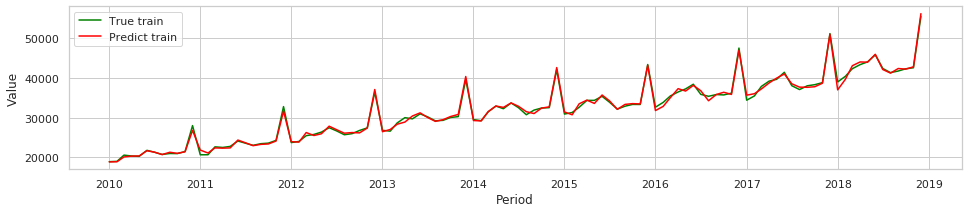

Average value: 31982, RMSE: 540, 1.688465% (RMSE/AVG)
Coefficient of determination: 0.995


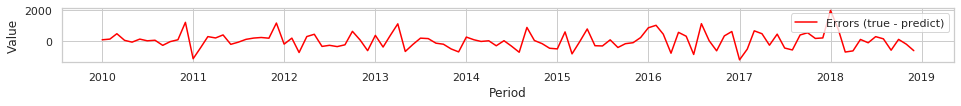

Остатки модели смещены на -2.32
Смещение составляет -0.01% от среднего значения прогнозируемой величины в 31984.62
Критерий Дики-Фуллера: p=1.784462498762176e-07

TEST PERIOD: 2019-01-01 00:00:00 2020-12-01 00:00:00 



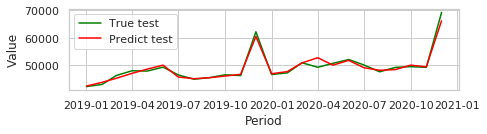

Average value: 49218, RMSE: 1150, 2.337450% (RMSE/AVG)
Coefficient of determination: 0.9578


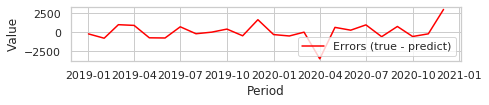

Остатки модели смещены на 90.76
Смещение составляет 0.18% от среднего значения прогнозируемой величины в 49127.41
Критерий Дики-Фуллера: p=3.0105964612332204e-05

TRAIN + TEST + FORECAST: 2019-01-01 00:00:00 2021-12-01 00:00:00 



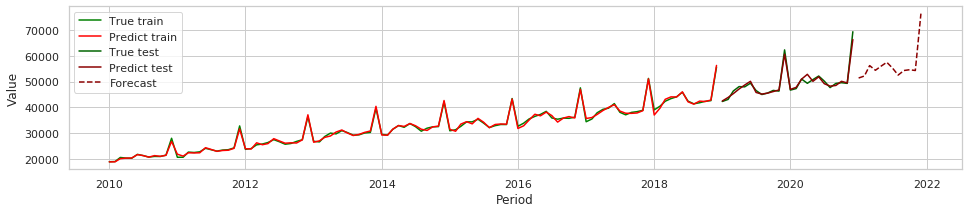

In [47]:
# data inverse of logarithm
inverse_train = predict_train + \
    timeseries_data['shift_1_12_log_Values'][timeseries_data['Split']=='Train'].to_numpy().reshape(-1,1)
inverse_train = inverse_train + \
    timeseries_data['shift_12_log_Values'][timeseries_data['Split']=='Train'].to_numpy().reshape(-1,1)
inverse_train = invboxcox(inverse_train, lmbda=0)

inverse_test = predict_test + \
    timeseries_data['shift_1_12_log_Values'][timeseries_data['Split']=='Test'].to_numpy().reshape(-1,1)
inverse_test = inverse_test + \
    timeseries_data['shift_12_log_Values'][timeseries_data['Split']=='Test'].to_numpy().reshape(-1,1)
inverse_test = invboxcox(inverse_test, lmbda=0)

forecast_unlog = invboxcox(forecast_data['log_Values'],lmbda=0)


# check the quality of the model on the training and test set, build a forecast

# select the params
name_report = 'ORIGINAL VALUES'
true_train = pd.DataFrame(timeseries_data['Values'][timeseries_data['Split']=='Train'])
true_test = pd.DataFrame(timeseries_data['Values'][timeseries_data['Split']=='Test'])
# predict_train, predict_test, forecast = predict_train_unlog, predict_test_unlog, forecast_unlog
train_period, test_period, forecast_period = trn_period, tst_period, frcst_period
model = model
features = Xy.columns[3:].to_list()
graph_train = True
graph_test = True
graph_forecast = True
graph_coef = False
size_graph_1_1, size_graph_1_2, size_graph_2_1, size_graph_2_2, size_graph_3, size_graph_4 = \
    (16,3), (16,1), (7,1.5), (7,1), (16,3), (16,1)

MODEL, RMSE, CoefDetrmntn, AVG, PERCENTS = make_report_NN(name_report, 
                true_train, true_test, inverse_train, inverse_test, forecast_unlog, 
                train_period, test_period, forecast_period, 
                model, features, graph_train, graph_test, graph_forecast, graph_coef,
                size_graph_1_1, size_graph_1_2, size_graph_2_1, size_graph_2_2, size_graph_3, size_graph_4)

### Save statistics from model and check it

In [48]:
# add row to data frame 
MODEL_NAME = 'stationary time-series only'
statistics = [MODEL, MODEL_NAME, RMSE, CoefDetrmntn, AVG, PERCENTS]
st_counter += 1

model_statistics.loc[st_counter] = statistics

report_pivot_model_statistics(model_statistics, train_period, test_period, forecast_period)


PIVOT TABLE "Multyple model statistics" on TEST DATA

Periods:
  - train:     2010-01-01 00:00:00 - 2018-12-01 00:00:00
  - test:      2019-01-01 00:00:00 - 2020-12-01 00:00:00
  - forecast:  2021-01-01 00:00:00 - 2021-12-01 00:00:00


,Model,Model_name,RMSE,Coef_DetRMNTN,AVG,PERCENTS
1,"Model_1(\n (linear): Linear(in_features=12, o...",time-series only,1509.62,0.9273,49218.17,3.0672
2,"Model_1(\n (linear): Linear(in_features=25, o...",time-series with exogenous features,1514.68,0.9268,49218.17,3.0775
3,"Model_1(\n (linear): Linear(in_features=25, o...",logarithm time-series with exogenous features,1282.85,0.9475,49218.17,2.6065
4,"Model_1(\n (linear): Linear(in_features=14, o...",stationary time-series with exogenous features,1163.11,0.9568,49218.17,2.3632
5,"Model_1(\n (linear): Linear(in_features=1, ou...",stationary time-series only,1150.45,0.9578,49218.17,2.3374


In [49]:
STOP

NameError: name 'STOP' is not defined